# Change Point Identification
- ported from python
- to detect change points in the time series of log(var) of gh500 in the North Atlantic
- use monthly data for simplicity and because spatial aggregation makes daily scale inconsistent

In [4]:
source("../RScripts/config.r")
source("../RScripts/plot_functions.r")
source("../RScripts/data_functions.r")
source("../RScripts/algo_functions.r")

options(repr.plot.width = 15, repr.plot.height = 10) # Adjust width & height


## Data preprocessing

In [ ]:
# 0. Open the netCDF file
target_file <- paste0(ENS_DATA_DIR, "geopotential.nc")
nc <- nc_open(target_file)

# Extract the variable 'z' and coordinate vectors
overall_z <- ncvar_get(nc, "z") # dimensions: lon x lat x time
lon <- ncvar_get(nc, "longitude")
lat <- ncvar_get(nc, "latitude")
time_data <- ncvar_get(nc, "valid_time")
time_origin <- sub(
    "seconds since ", "",
    ncatt_get(nc, "valid_time", "units")$value
)
time_whole <- as.Date(as.POSIXct(time_data,
    origin = time_origin,
    tz = "UTC"
))

# Close the file
nc_close(nc)

# Precompute latitude-based weights
# For weighting, repeat cos(lat) for each longitude
lat_weights <- cos(lat * pi / 180)
lat_mat <- rep(lat_weights, each = length(lon))
lon_lat_size <- length(lon) * length(lat)
weights_norm <- lat_mat / sum(lat_mat)

# 1-2: Compute spatially weighted log-average for each time slice
log_spatial_avg <- vapply(
    seq_along(time_whole),
    function(i) {
        # extract slice
        slice <- overall_z[, , i]
        # take log
        log_slice <- log(slice)
        # vectorize & apply weights
        mean(log_slice, na.rm = TRUE, weights = weights_norm)
    },
    numeric(1)
)

# 3. Assemble into a data frame and calculate monthly averages
df <- tibble(
    date        = time_whole,
    log_value   = log_spatial_avg
) %>%
    mutate(
        year  = year(date),
        month = month(date)
    ) %>%
    group_by(year, month) %>%
    summarize(
        log_variance = mean(log_value, na.rm = TRUE),
        .groups      = "drop"
    ) %>%
    arrange(year, month)

# 4-5: Add additional columns
df <- df %>%
    mutate(
        date    = make_date(year, month, 1),
        # seasonal cycle transforms
        sin_mon = sin(2 * pi * month / 12),
        cos_mon = cos(2 * pi * month / 12),
        # number of months since first data point
        mon_no  = as.integer((year - first(year)) * 12 + (month - first(month)))
    )

# The result 'df' has columns: year, month, log_variance,
# date (first of month), sin_mon, cos_mon, mon_no

# Display the result
print(df)


# A tibble: 1,020 × 7
    year month log_variance date         sin_mon   cos_mon mon_no
   <int> <int>        <dbl> <date>         <dbl>     <dbl>  <int>
 1  1940     1         5.49 1940-01-01  5   e- 1  8.66e- 1      0
 2  1940     2         5.38 1940-02-01  8.66e- 1  5   e- 1      1
 3  1940     3         5.34 1940-03-01  1   e+ 0  6.12e-17      2
 4  1940     4         5.47 1940-04-01  8.66e- 1 -5   e- 1      3
 5  1940     5         5.34 1940-05-01  5   e- 1 -8.66e- 1      4
 6  1940     6         5.38 1940-06-01  1.22e-16 -1   e+ 0      5
 7  1940     7         5.32 1940-07-01 -5.00e- 1 -8.66e- 1      6
 8  1940     8         5.45 1940-08-01 -8.66e- 1 -5.00e- 1      7
 9  1940     9         5.35 1940-09-01 -1   e+ 0 -1.84e-16      8
10  1940    10         5.44 1940-10-01 -8.66e- 1  5   e- 1      9
# ℹ 1,010 more rows


# Look at Seasonality of Dataset

**How exactly does the seasonal cycle in the dataset look? And how does it change across change points?**

To find change points and estimate parameters, used [mcp](https://lindeloev.github.io/mcp/index.html); but it didnt work that well and does not permit multiple predictors. So stick with strucchange

1. Find change points assuming annual slope, offset and variance varies 
    1. With the seasonal cycle not varying
    2. With the seasonal cycle varying
3. Visualize
    1. box-whiskers plot for each month for each segment along with a best fit sin-cos
    2. scatter plot with x: amplitude, y: phase (month of maximum) along with uncertainty for annual and segments

In [6]:
ordered_cp_df <- function(bp_est_monthly, data) {
    # Get summary and confidence intervals
    bp_summary <- summary(bp_est_monthly)
    ci_bp_monthly <- confint(bp_est_monthly,
        vcov = sandwich::NeweyWest,
        level = 0.95
    )

    # Extract breakpoints
    cp_indices <- bp_summary$breakpoints[length(bp_est_monthly$breakpoints), ]

    # Compute NA counts for ordering and filter non-NA values
    na_counts <- colSums(is.na(bp_summary$breakpoints))
    valid_indices <- !is.na(cp_indices)
    ordered_indices <- order(na_counts[valid_indices], decreasing = FALSE)
    cp_indices_ordered <- cp_indices[valid_indices][ordered_indices]

    # Convert indices to dates
    matched_indices <- match(cp_indices_ordered, ci_bp_monthly$confint[, 2])
    cp_dates <- data$date[cp_indices_ordered]
    cp_dates_lower <- data$date[ci_bp_monthly$confint[matched_indices, 1]]
    cp_dates_upper <- data$date[ci_bp_monthly$confint[matched_indices, 3]]

    # Create ordered change point data frame
    cp_df <- data.frame(
        cp_date = cp_dates,
        cp_date_lower = cp_dates_lower,
        cp_date_upper = cp_dates_upper,
        cp_no = seq_along(cp_dates) # Identifier for the change points
    )

    return(cp_df)
}



	 Confidence intervals for breakpoints
	 of optimal 6-segment partition: 

Call:
confint.breakpointsfull(object = ar_fit_glob, het.reg = TRUE, 
    het.err = TRUE, vcov. = vcovHC, sandwich = TRUE)

Breakpoints at observation number:
  2.5 % breakpoints 97.5 %
1   101         102    103
2   210         211    212
3   469         471    472
4   699         700    701
5   824         825    828

Corresponding to breakdates:
       2.5 % breakpoints    97.5 %
1 0.09901961   0.1000000 0.1009804
2 0.20588235   0.2068627 0.2078431
3 0.45980392   0.4617647 0.4627451
4 0.68529412   0.6862745 0.6872549
5 0.80784314   0.8088235 0.8117647


cp_date,cp_date_lower,cp_date_upper,cp_no
<date>,<date>,<date>,<int>
1948-06-01,1948-05-01,1948-10-01,1
1998-04-01,1997-10-01,1998-11-01,2
1957-07-01,1957-06-01,1957-09-01,3
1979-03-01,1977-10-01,1979-05-01,4
2008-09-01,2007-08-01,2010-01-01,5


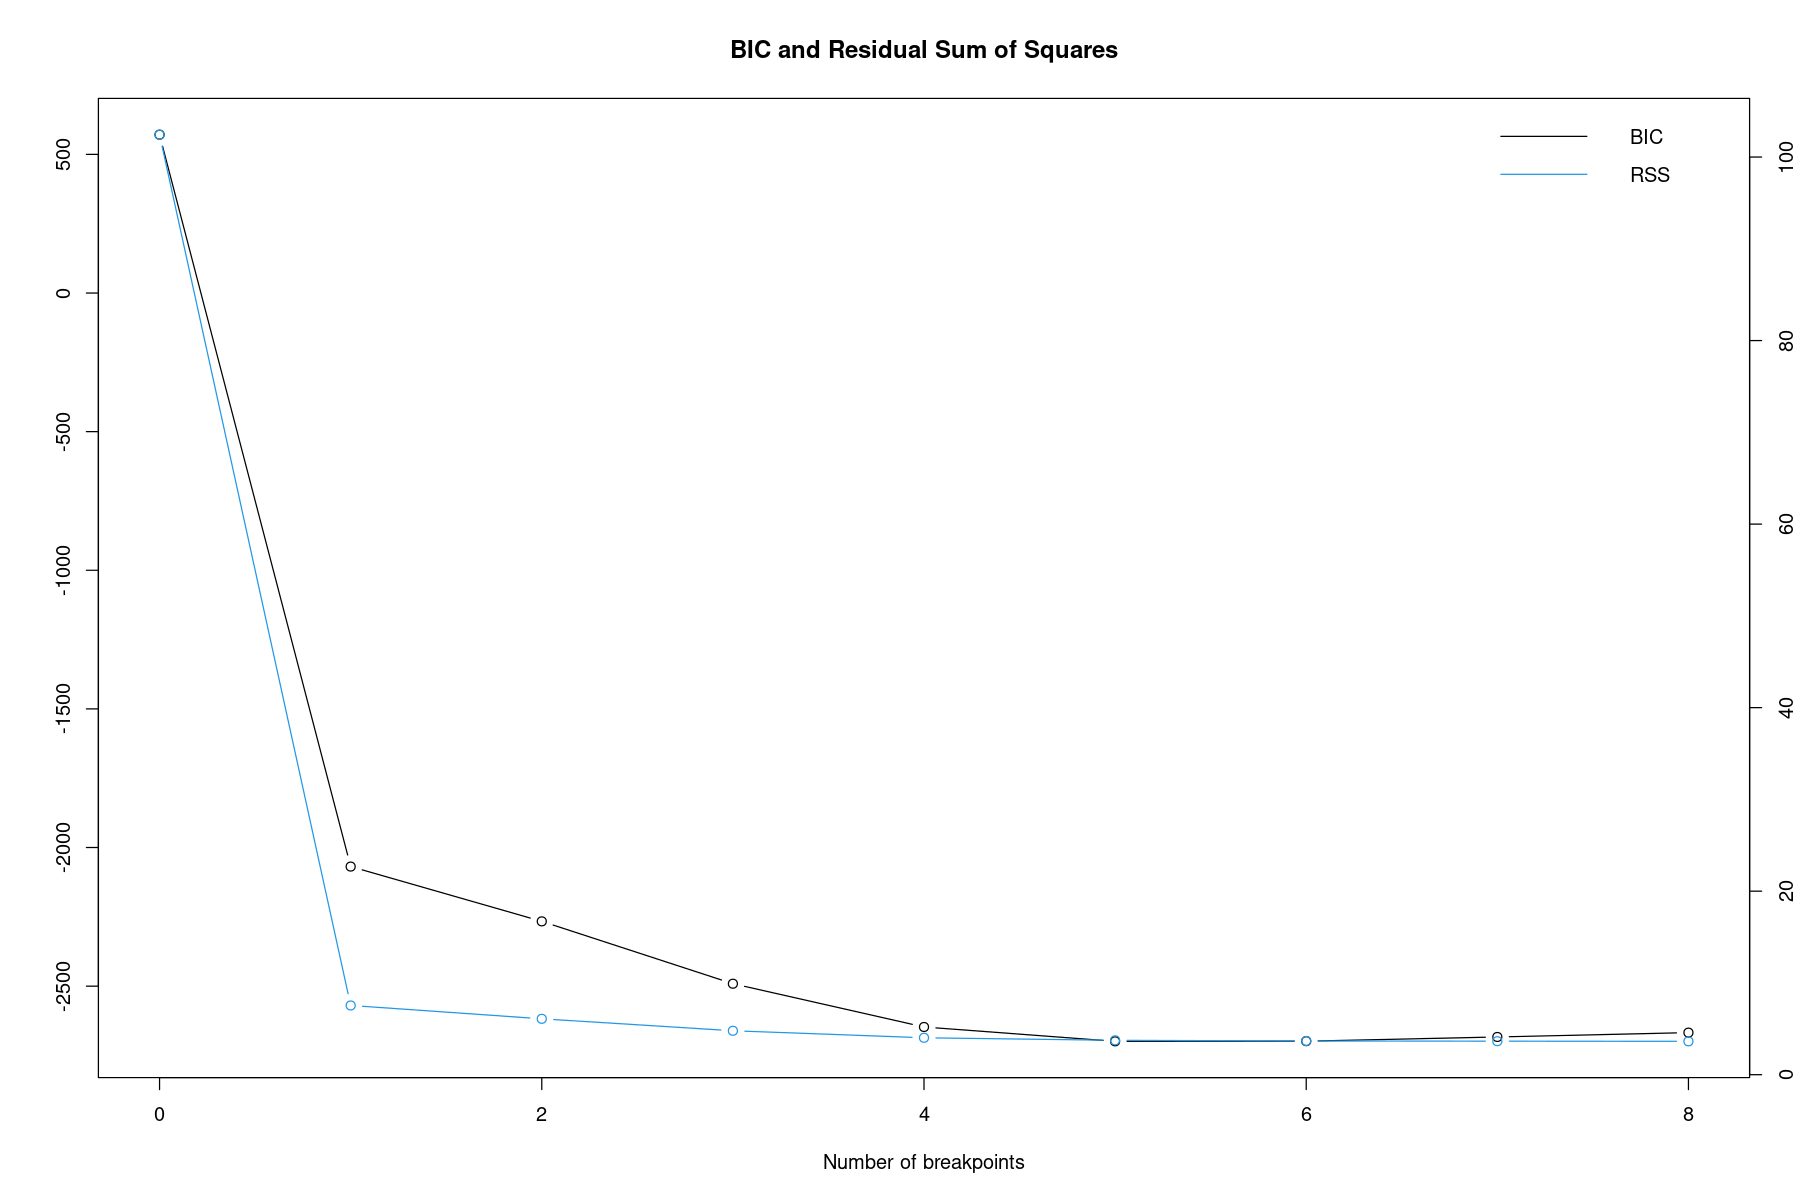

In [8]:
glob_ar_mod <- nlme::gls(
    log_variance ~ 1,
    data        = df,
    correlation = corAR1(form = ~mon_no)
)

filtered_df <- df %>%
    mutate(ar_filtered = residuals(glob_ar_mod))


ar_fit_glob <- breakpoints(
    ar_filtered ~ year,
    data     = filtered_df,
    h        = .1,
    breaks   = NULL
)
par(bg = "white")
plot(ar_fit_glob)
print(confint(ar_fit_glob,
    het.err = TRUE,
    het.reg = TRUE,
    sandwich = TRUE,
    vcov. = vcovHC
))

cp_df <- ordered_cp_df(ar_fit_glob, df)
cp_df


In [33]:
df$segment_no_seas <- breakfactor(ar_fit_glob)
df <- df %>%
    group_by(segment_no_seas) %>%
    mutate(mon_no = row_number()) %>%
    ungroup()

# Fit the segmented linear model with segment-specific predictors
lmod_monthly_no_seas <- nlme::gls(
    log_variance ~ segment_no_seas +
        segment_no_seas:year - 1,
    data = df,
    correlation = corAR1(form = ~ mon_no | segment_no_seas),
    weights = varIdent(form = ~ 1 | segment_no_seas)
)

# Summarize the segmented model results
summary(lmod_monthly_no_seas)


Generalized least squares fit by REML
  Model: log_variance ~ segment_no_seas + segment_no_seas:year - 1 
  Data: df 
        AIC       BIC   logLik
  -3774.167 -3680.768 1906.083

Correlation Structure: AR(1)
 Formula: ~mon_no | segment_no_seas 
 Parameter estimate(s):
      Phi 
0.7771002 
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment_no_seas 
 Parameter estimates:
 segment1  segment2  segment3  segment4  segment5  segment6 
1.0000000 0.5173364 0.4147184 0.3829189 0.3478121 0.3756102 

Coefficients:
                                 Value Std.Error    t-value p-value
segment_no_seassegment1      286.39690 24.329157  11.771756  0.0000
segment_no_seassegment2      118.24613 11.416747  10.357252  0.0000
segment_no_seassegment3       28.85537  2.798916  10.309481  0.0000
segment_no_seassegment4       16.64967  3.134928   5.311020  0.0000
segment_no_seassegment5       57.50833  6.639337   8.661758  0.0000
segment_no_seassegment6       11.51

pdf 
  2

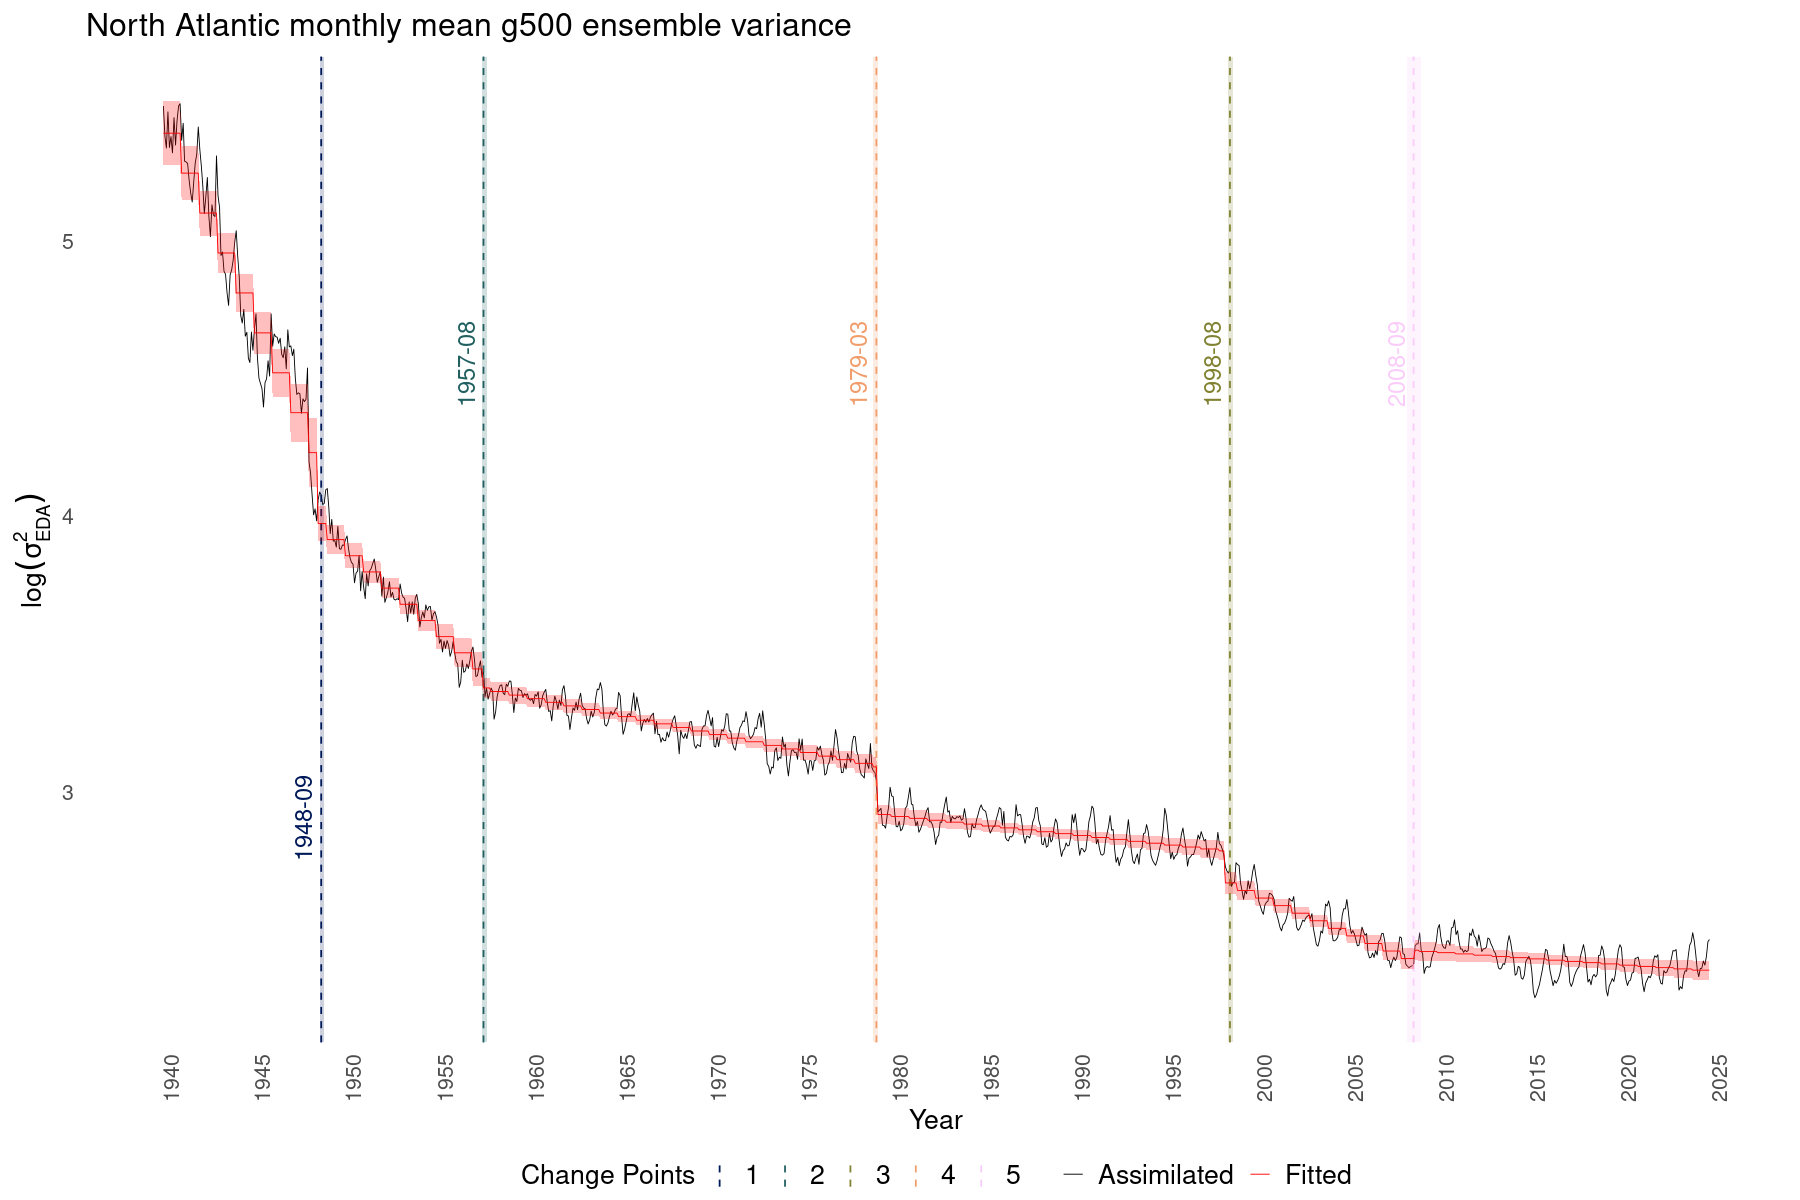

In [34]:
p <- plot_change_points(
    data = df,
    cp_df = cp_df,
    theme_pub = NULL,
    show_ci = TRUE
)

fitted_layers <- add_fitted_line_ci(lmod_monthly_no_seas, df)
for (layer in fitted_layers) {
    p <- p + layer
}
p + THEME_PUB_LARGE
save_plot(p, "ChangePointsNoSeasLarge.pdf", width = 9.5, height = 4.25)


In [35]:
seasonal_model <- nlme::gls(
    log_variance ~ year:segment_no_seas + segment_no_seas +
        sin_mon + cos_mon - 1,
    data = df,
    correlation = corAR1(form = ~ mon_no | segment_no_seas),
    weights = varIdent(form = ~ 1 | segment_no_seas)
)

summary(seasonal_model)


Generalized least squares fit by REML
  Model: log_variance ~ year:segment_no_seas + segment_no_seas + sin_mon +      cos_mon - 1 
  Data: df 
        AIC     BIC   logLik
  -4042.889 -3939.7 2042.444

Correlation Structure: AR(1)
 Formula: ~mon_no | segment_no_seas 
 Parameter estimate(s):
      Phi 
0.7132506 
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment_no_seas 
 Parameter estimates:
 segment1  segment2  segment3  segment4  segment5  segment6 
1.0000000 0.5650459 0.4095042 0.3181734 0.2978597 0.3139700 

Coefficients:
                                 Value Std.Error    t-value p-value
segment_no_seassegment1      288.77594 18.847227  15.321932   0e+00
segment_no_seassegment2      122.33167  9.642245  12.687052   0e+00
segment_no_seassegment3       29.34922  2.065839  14.206930   0e+00
segment_no_seassegment4       17.79890  1.952100   9.117823   0e+00
segment_no_seassegment5       59.61134  4.355319  13.687022   0e+00
segment_no_sea

In [36]:
trend_only_df <- df %>%
    mutate(
        sin_mon = 0,
        cos_mon = 0
    )

df <- df %>%
    mutate(
        fitted_trend_only = predict(seasonal_model, newdata = trend_only_df)
    )

# The “deseasonalized” response is
#    y_i^(ds) = log_variance_i - fitted_trend_i
df <- df %>%
    mutate(
        y_seas = log_variance - fitted_trend_only
    )

# ── 4) Extract the seasonal‐term coefficients + 2×2 covariance ───────────────────
coefs_all <- coef(seasonal_model)
beta_sin <- coefs_all["sin_mon"]
beta_cos <- coefs_all["cos_mon"]

V_all <- vcov(seasonal_model)
V_seas <- V_all[c("sin_mon", "cos_mon"), c("sin_mon", "cos_mon")]

df_resid <- nrow(df) - length(coef(seasonal_model))

# ── 5) Build a 12‐row data.frame giving month = 1…12, sin_mon, cos_mon ─────────
new_season <- tibble(
    month = 1:12
) %>%
    mutate(
        sin_mon = sin(2 * pi * (month / 12)),
        cos_mon = cos(2 * pi * (month / 12))
    ) %>%
    rowwise() %>%
    mutate(
        # point‐estimate of the seasonal fit
        fit = beta_sin * sin_mon + beta_cos * cos_mon,

        # its standard error:  sqrt([s c] %*% V_seas %*% [s; c])
        se = sqrt(
            c(sin_mon, cos_mon) %*% V_seas %*% matrix(c(sin_mon, cos_mon), ncol = 1)
        )
    ) %>%
    ungroup() %>%
    mutate(
        lwr = fit - qt(0.975, df = df_resid) * se,
        upr = fit + qt(0.975, df = df_resid) * se
    )


pdf 
  2

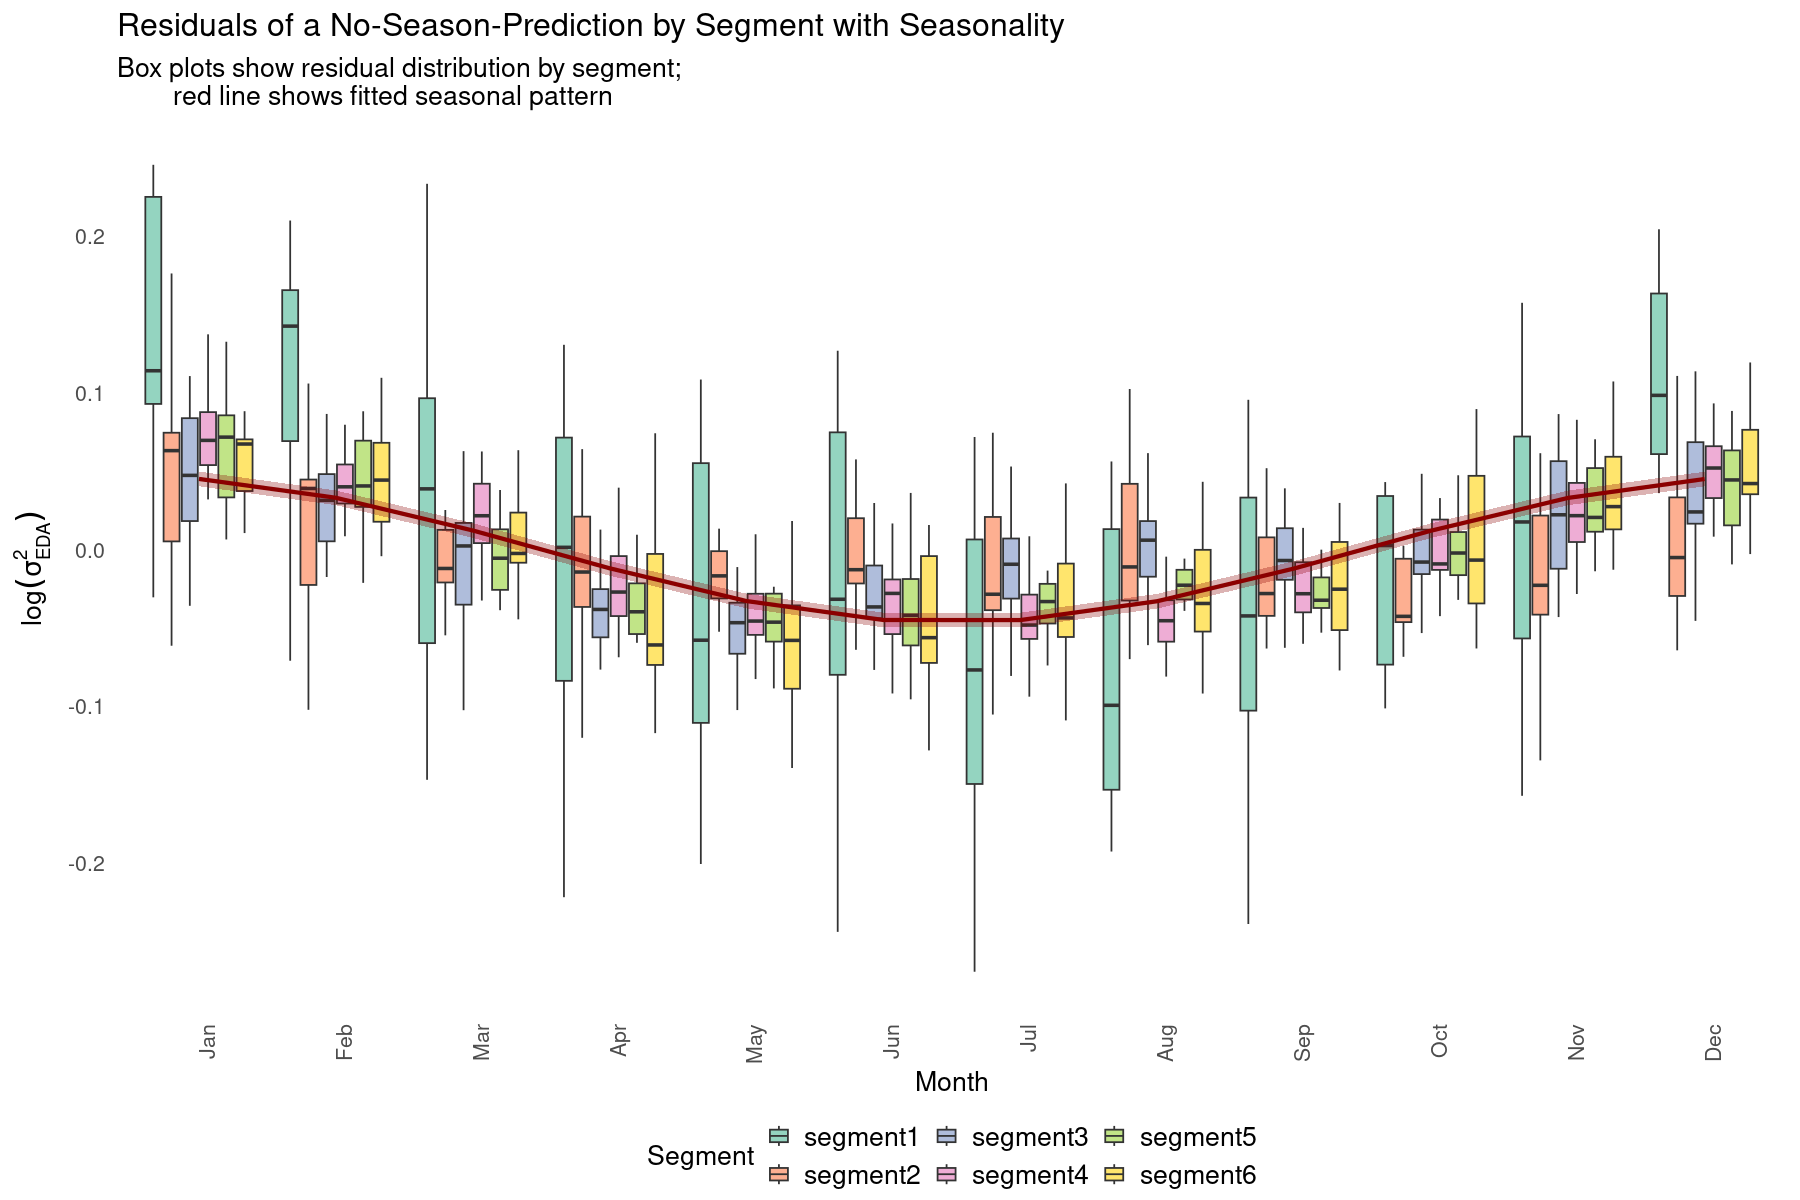

In [37]:
p <- ggplot(df, aes(x = factor(month), fill = segment_no_seas)) +
    # Box plots for residuals by month and segment
    geom_boxplot(aes(y = y_seas),
        alpha = 0.7,
        outlier.shape = NA, # Remove outliers
        width = 0.7, # Make boxes narrower
        position = position_dodge(width = 0.8) # Space out the boxes
    ) +
    # Use a color palette that works well with 6 segments
    scale_fill_brewer(type = "qual", palette = "Set2", name = "Segment") +
    geom_ribbon(
        data = new_season,
        aes(x = month, ymin = lwr, ymax = upr, group = 1, fill = NULL),
        alpha = 0.3,
        fill = "darkred",
        inherit.aes = FALSE
    ) +
    # Add seasonal trend line
    geom_line(
        data = new_season,
        aes(x = month, y = fit, group = 1, fill = NULL),
        color = "darkred",
        size = 1.2,
        linetype = "solid",
        inherit.aes = FALSE
    ) +
    # Customize the plot
    scale_x_discrete(labels = month.abb) +
    labs(
        title = "Residuals of a No-Season-Prediction by Segment with Seasonality",
        subtitle = "Box plots show residual distribution by segment;
        red line shows fitted seasonal pattern",
        x = "Month",
        y = TeX("$\\log(\\sigma^{2}_{EDA})$")
    ) +
    THEME_PUB_LARGE

# Display the plot
print(p)
save_plot(p, "MonthlyResSingleSeason.pdf", width = 9, height = 5)


**The above shows that it is crucial to allow the seasonal cycle to vary between segments! See also the last section in this notebook**

## Multiple structural change models (Bai & Perron, 2003)
**Challenge:** Choose either max number of breakpoints or minimum segment size?

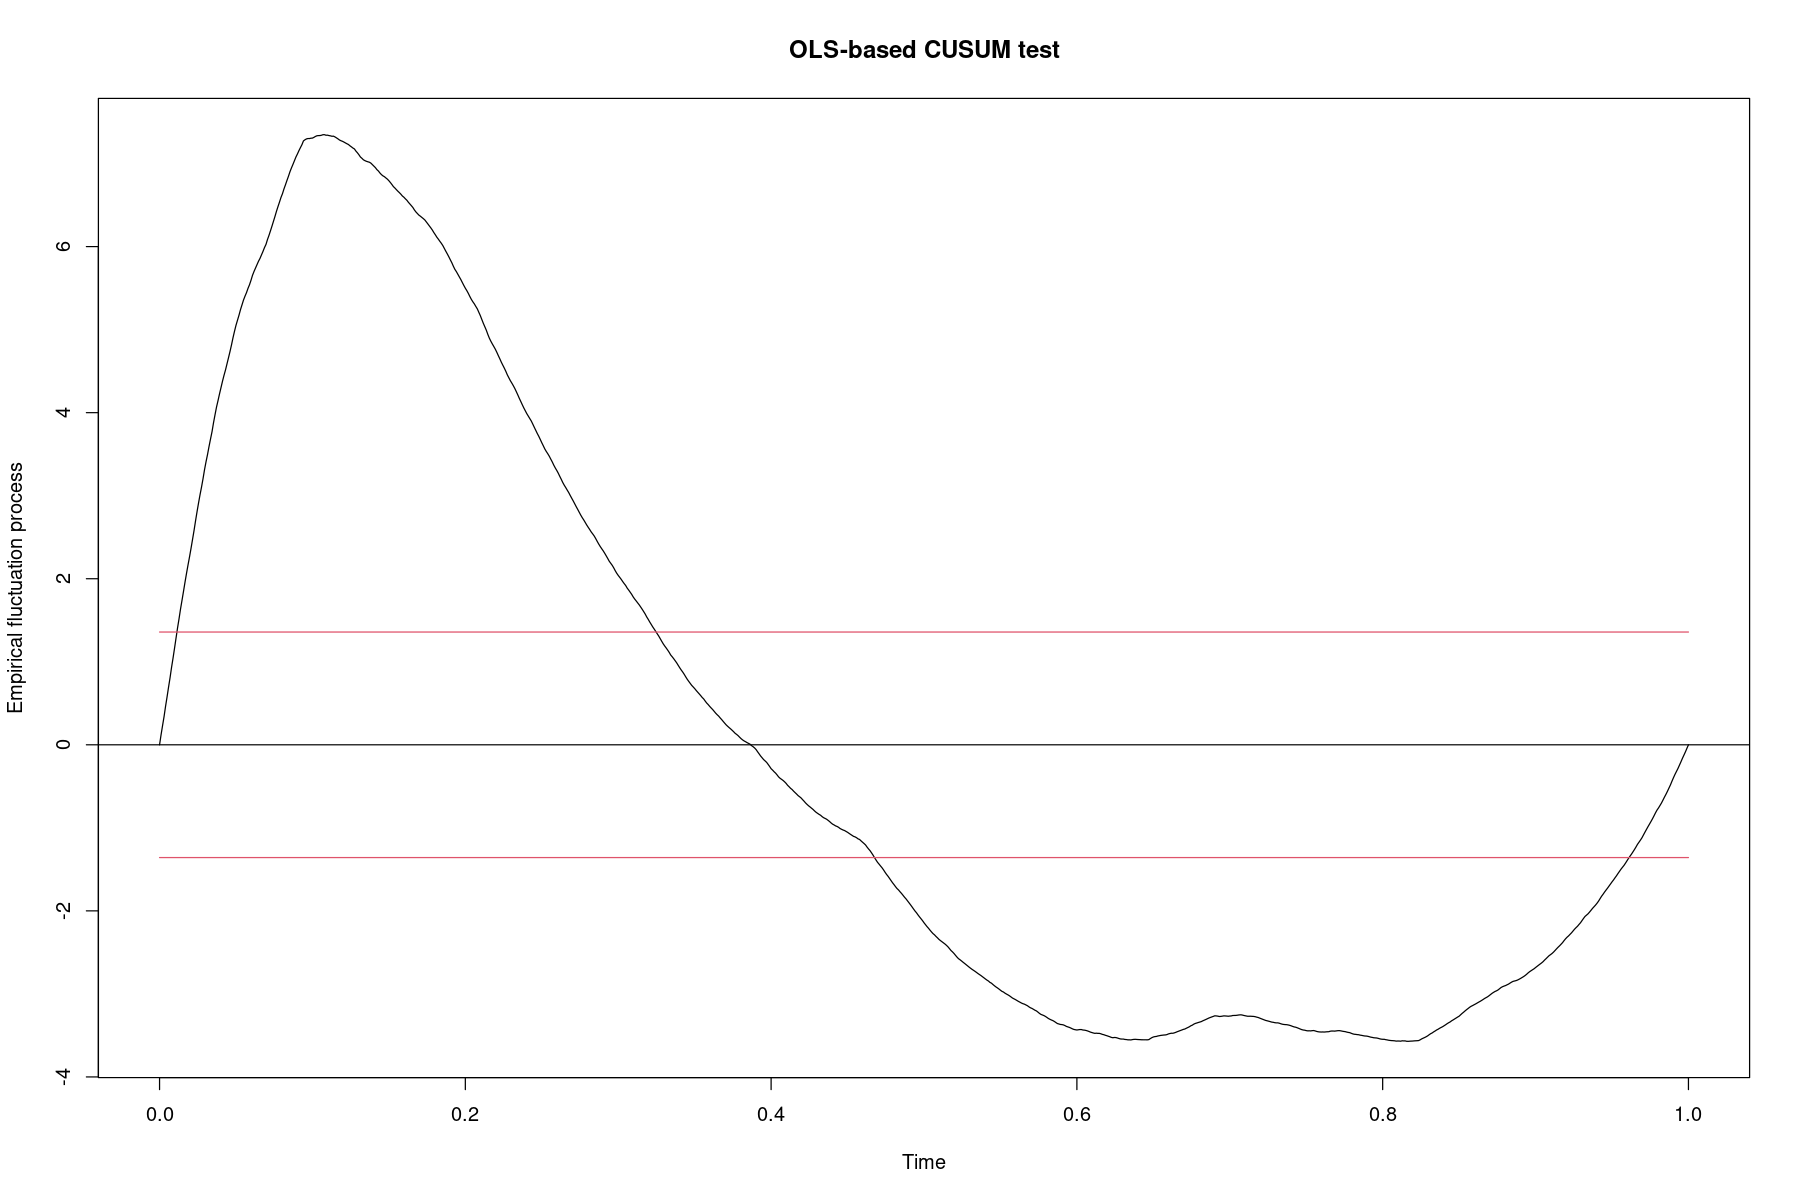

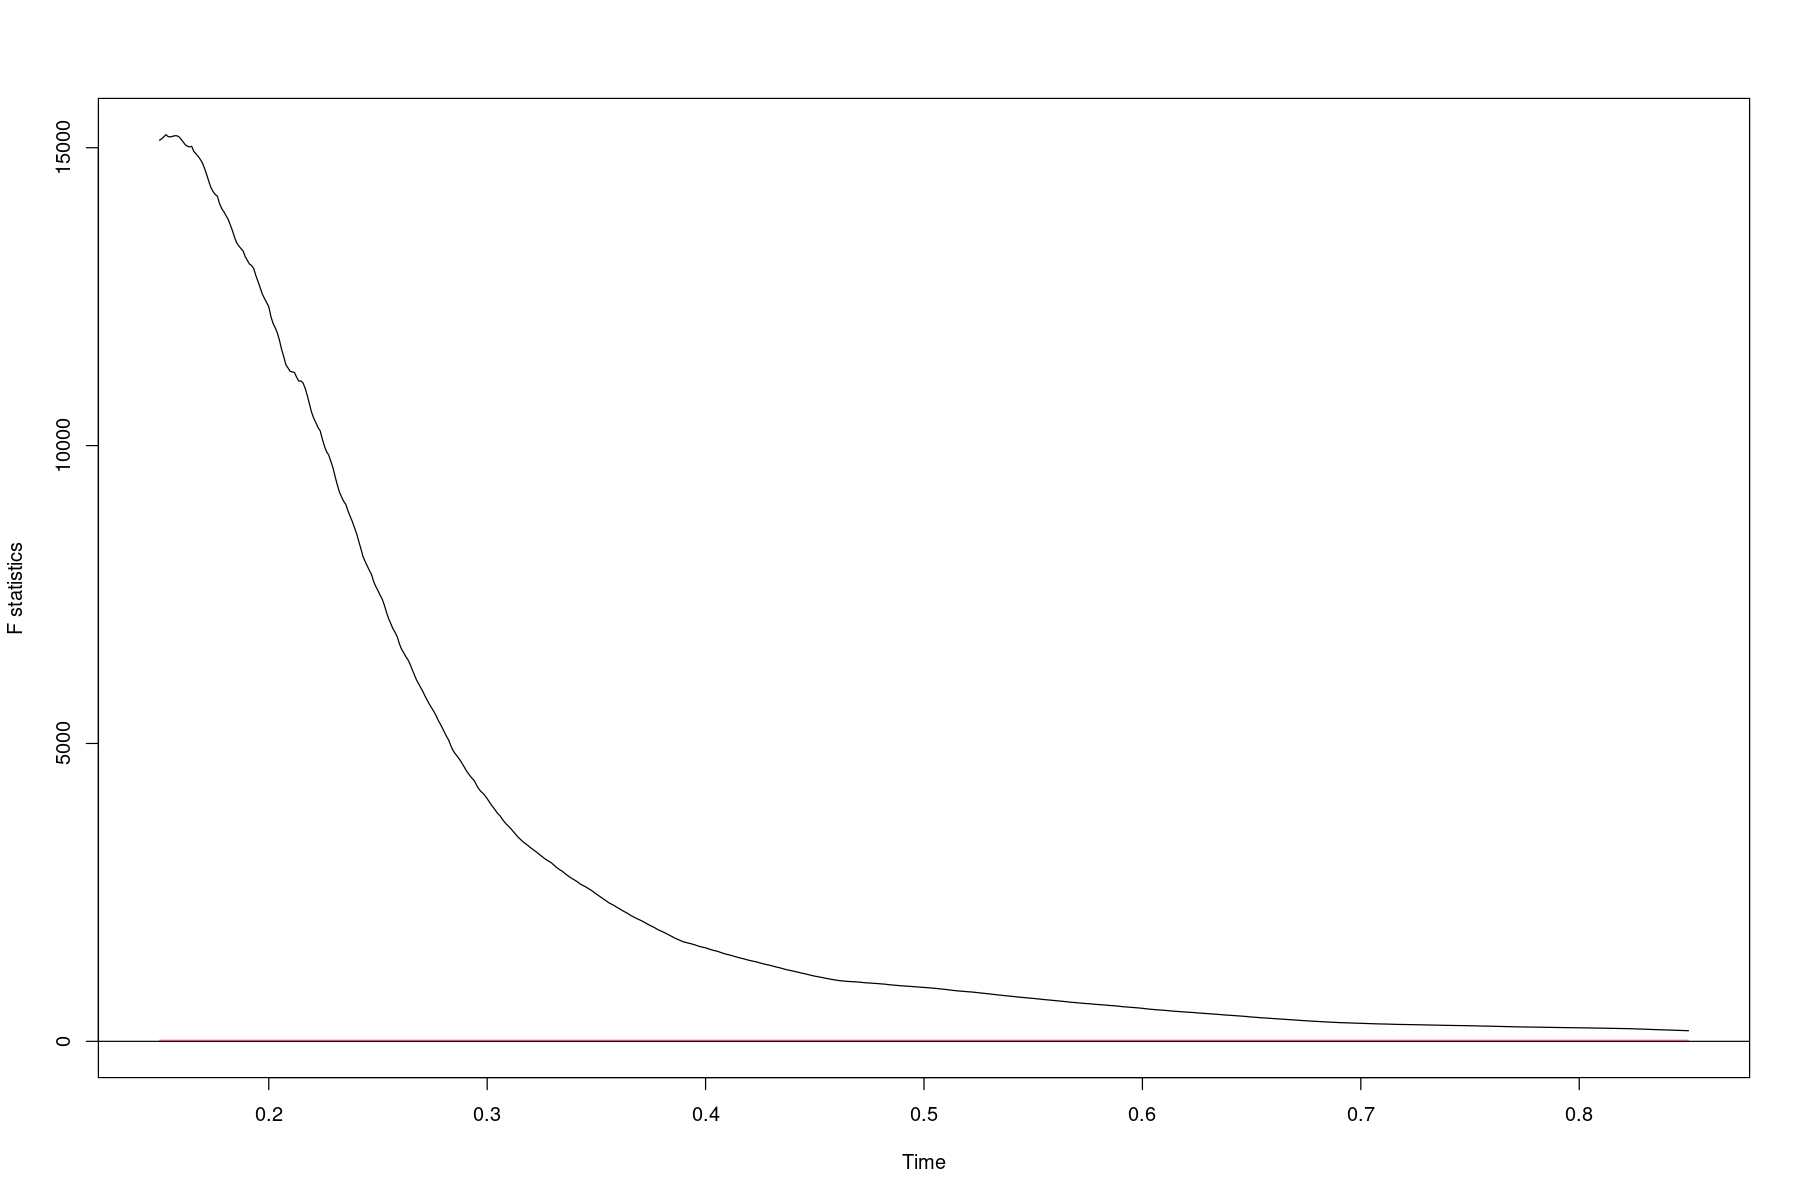

In [38]:
par(bg = "white")

ocus <- efp(
    formula = ar_filtered ~ year + sin_mon + cos_mon,
    data = filtered_df,
    type = "OLS-CUSUM"
)

plot(ocus)

fs <- Fstats(ar_filtered ~ year + sin_mon + cos_mon, data = filtered_df)
plot(fs)


pdf 
  2


	 Optimal 6-segment partition: 

Call:
breakpoints.formula(formula = ar_filtered ~ year + sin_mon + 
    cos_mon, h = 0.1, breaks = NULL, data = filtered_df)

Breakpoints at observation number:
105 212 471 704 825 

Corresponding to breakdates:
0.1029412 0.2078431 0.4617647 0.6901961 0.8088235 

	 Confidence intervals for breakpoints
	 of optimal 6-segment partition: 

Call:
confint.breakpointsfull(object = bp_est_monthly, het.reg = TRUE, 
    het.err = TRUE, vcov. = vcovHC, sandwich = TRUE)

Breakpoints at observation number:
  2.5 % breakpoints 97.5 %
1   104         105    106
2   211         212    213
3   470         471    472
4   703         704    705
5   824         825    827

Corresponding to breakdates:
      2.5 % breakpoints    97.5 %
1 0.1019608   0.1029412 0.1039216
2 0.2068627   0.2078431 0.2088235
3 0.4607843   0.4617647 0.4627451
4 0.6892157   0.6901961 0.6911765
5 0.8078431   0.8088235 0.8107843


cp_date,cp_date_lower,cp_date_upper,cp_no
<date>,<date>,<date>,<int>
1948-09-01,1948-08-01,1948-11-01,1
1957-08-01,1957-07-01,1957-10-01,2
1998-08-01,1998-07-01,1998-10-01,3
1979-03-01,1979-01-01,1979-04-01,4
2008-09-01,2008-05-01,2009-02-01,5


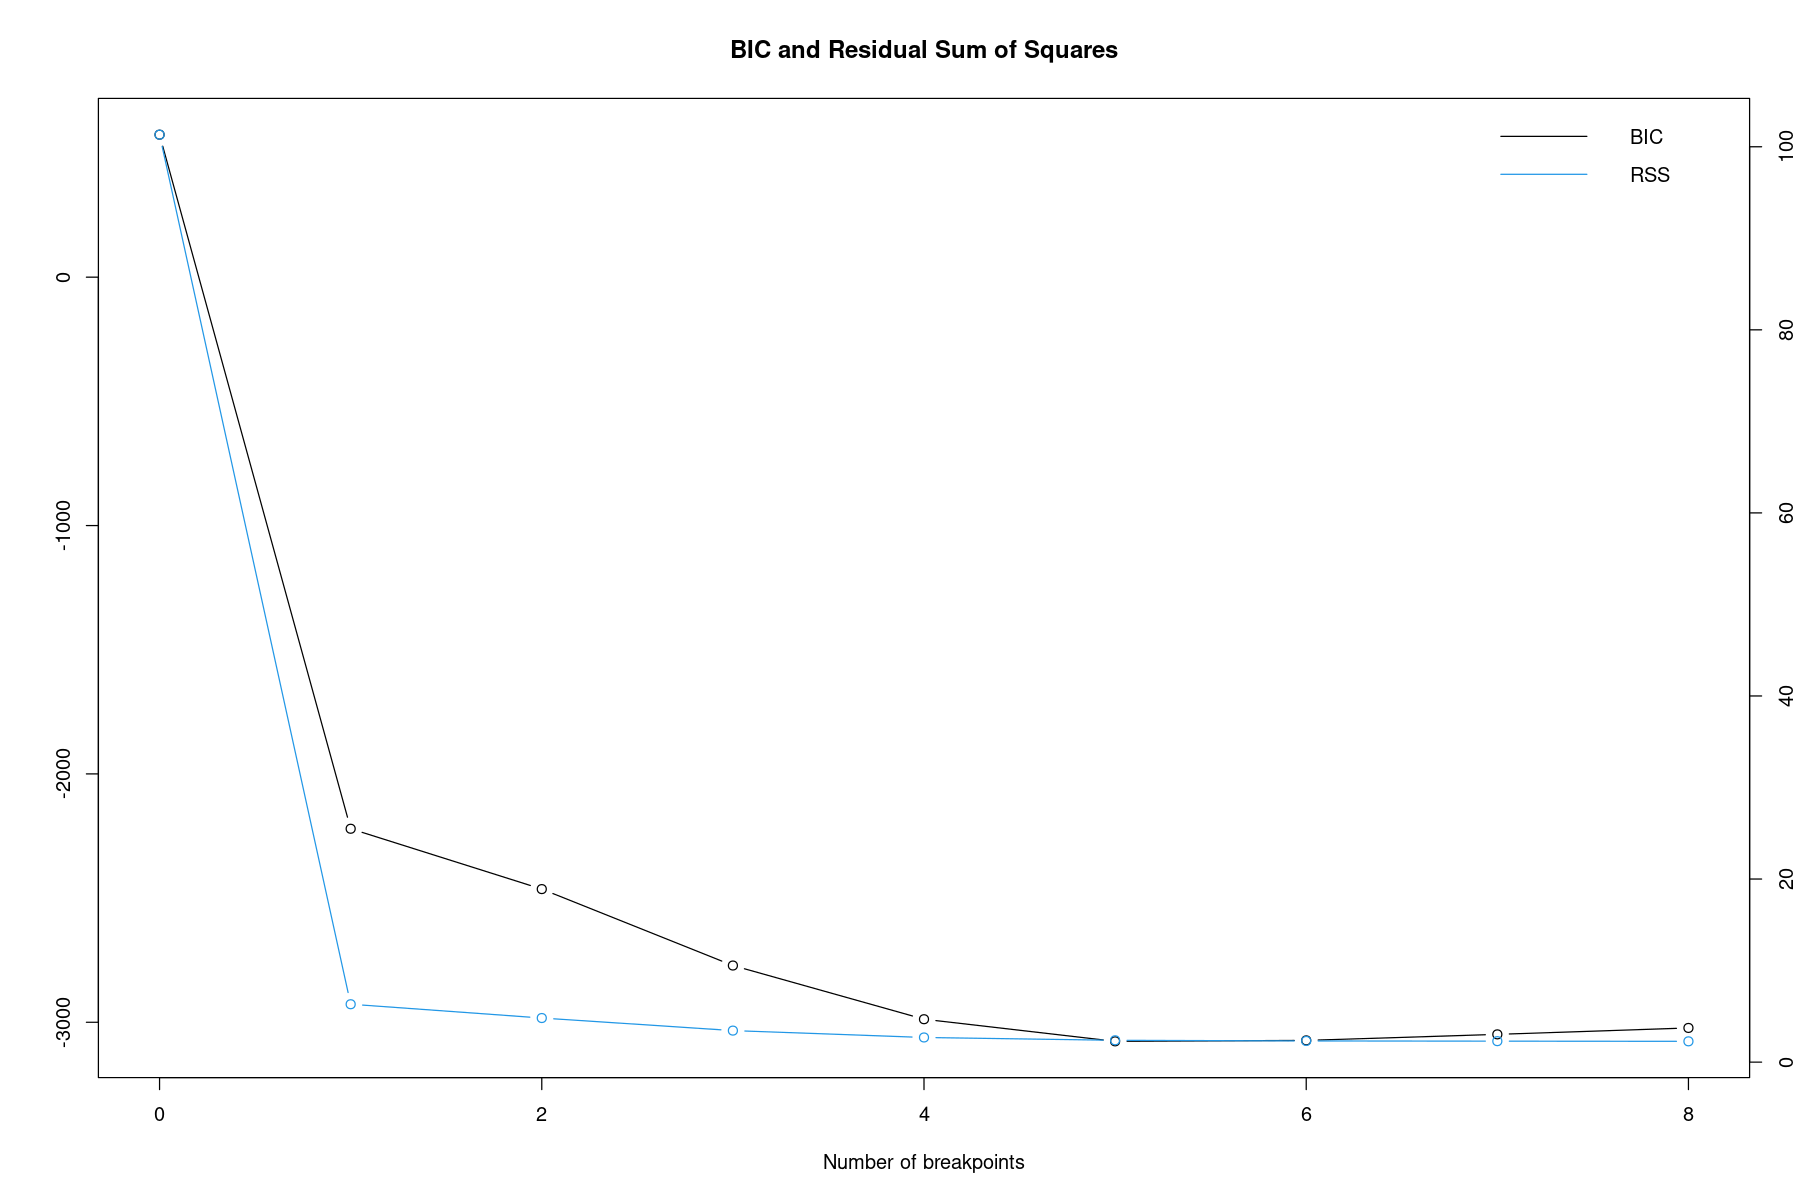

In [39]:
# Estimate breakpoints with seasonal predictors differing in each segment
# Control for AR(1)
bp_est_monthly <- breakpoints(ar_filtered ~ year + sin_mon + cos_mon,
    data = filtered_df,
    h = .1,
    breaks = NULL
)
par(bg = "white")
plot(bp_est_monthly)
pdf(paste0(OUT_DIR, "BIC_breakpoints.pdf"), width = 4, height = 3)
plot(bp_est_monthly)
dev.off()
print(bp_est_monthly)
print(confint(bp_est_monthly,
    het.err = TRUE,
    het.reg = TRUE,
    sandwich = TRUE,
    vcov. = vcovHC
))
cp_df <- ordered_cp_df(bp_est_monthly, df)
cp_df


In [40]:
df$segment <- breakfactor(bp_est_monthly)

df <- df %>%
    group_by(segment) %>%
    mutate(mon_no = row_number()) %>%
    ungroup()
# Fit the segmented linear model with segment-specific predictors
lmod_seas_monthly <- nlme::gls(
    log_variance ~ segment +
        segment:year + segment:sin_mon + segment:cos_mon - 1,
    data = df,
    correlation = corAR1(form = ~ mon_no | segment),
    weights = varIdent(form = ~ 1 | segment)
)

# Summarize the segmented model results
summary(lmod_seas_monthly)


Generalized least squares fit by REML
  Model: log_variance ~ segment + segment:year + segment:sin_mon + segment:cos_mon -      1 
  Data: df 
       AIC       BIC  logLik
  -4014.38 -3862.364 2038.19

Correlation Structure: AR(1)
 Formula: ~mon_no | segment 
 Parameter estimate(s):
      Phi 
0.6913146 
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | segment 
 Parameter estimates:
 segment1  segment2  segment3  segment4  segment5  segment6 
1.0000000 0.5572735 0.4062897 0.3222751 0.2912634 0.3262311 

Coefficients:
                            Value Std.Error    t-value p-value
segmentsegment1         293.18767 16.608081  17.653314  0.0000
segmentsegment2         119.99888  8.970384  13.377229  0.0000
segmentsegment3          28.22258  1.860278  15.171163  0.0000
segmentsegment4          18.50783  1.738457  10.646124  0.0000
segmentsegment5          55.15617  4.051966  13.612199  0.0000
segmentsegment6          12.03803  2.316974   5.195583  0.00

Warning message:
“Using size for a discrete variable is not advised.”


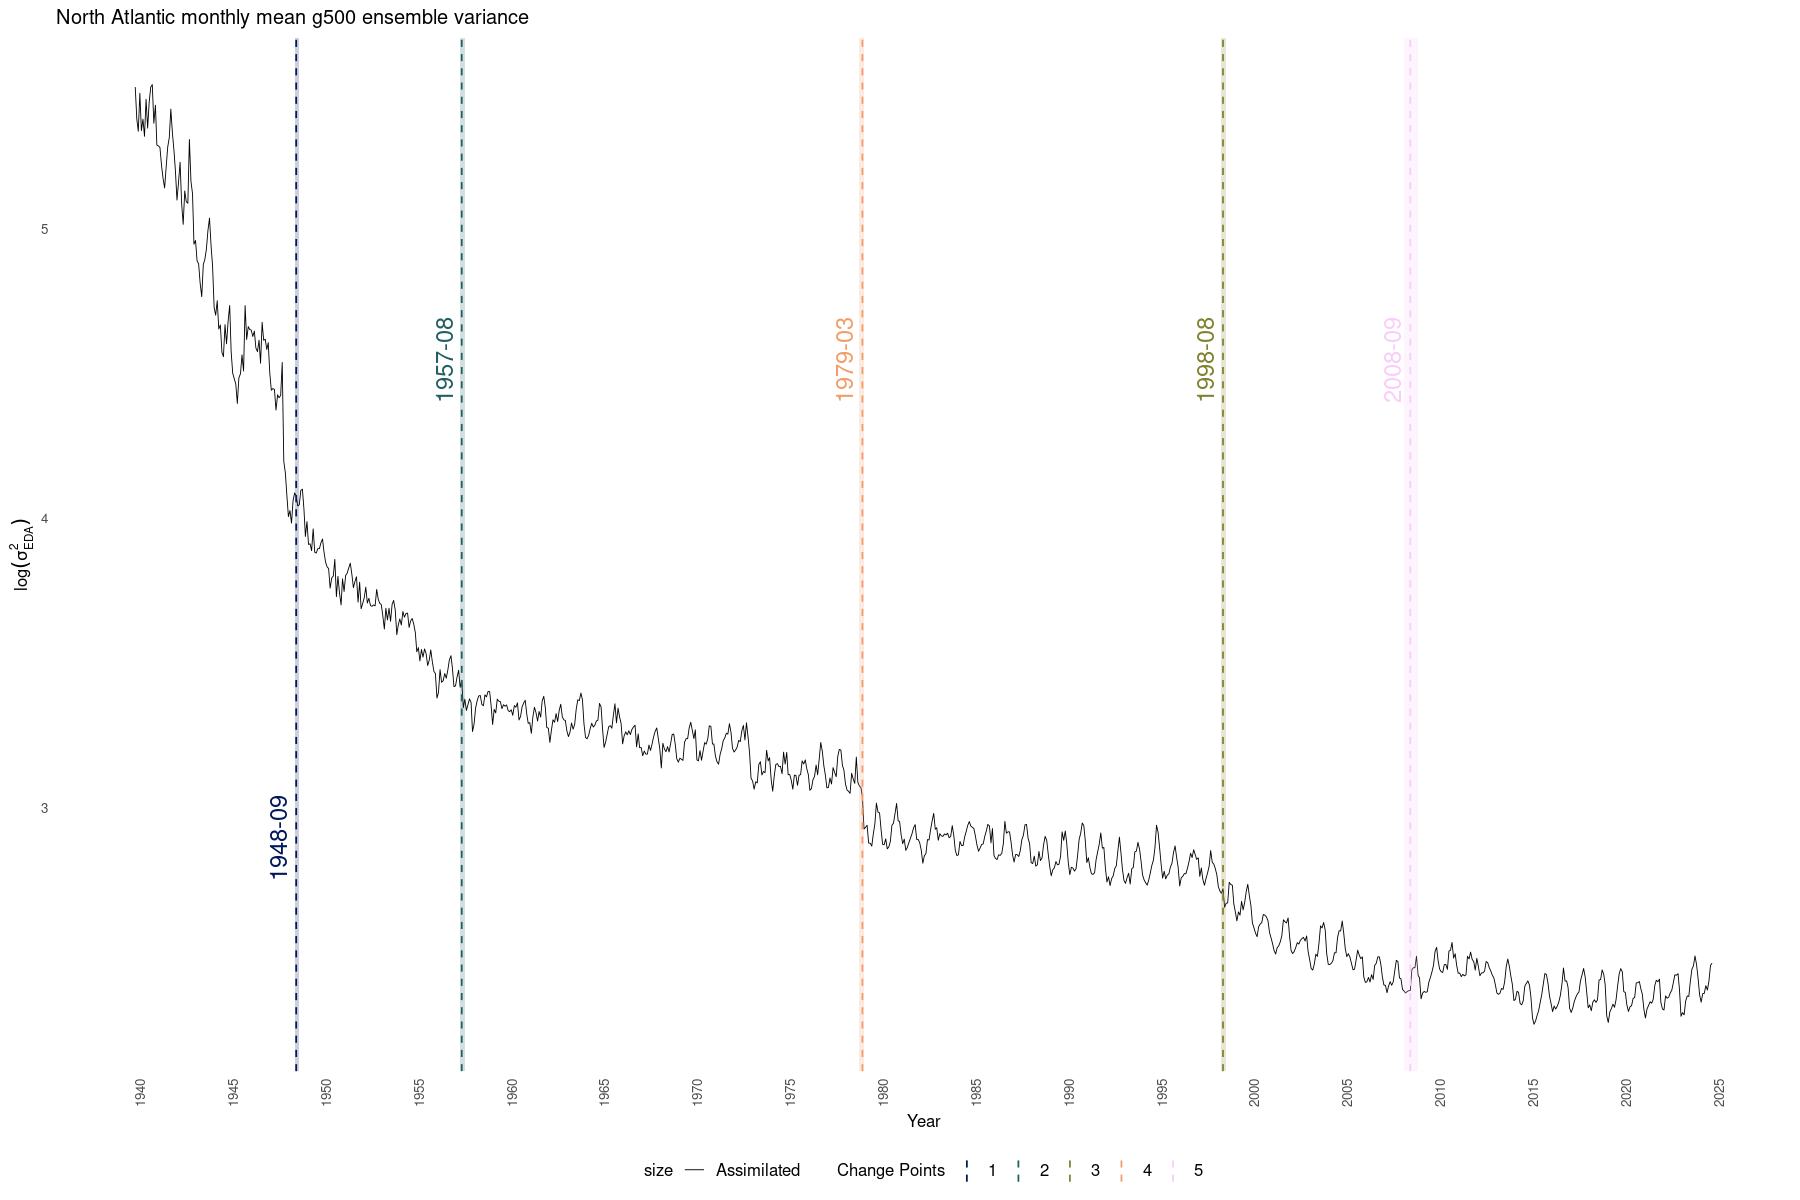

pdf 
  2

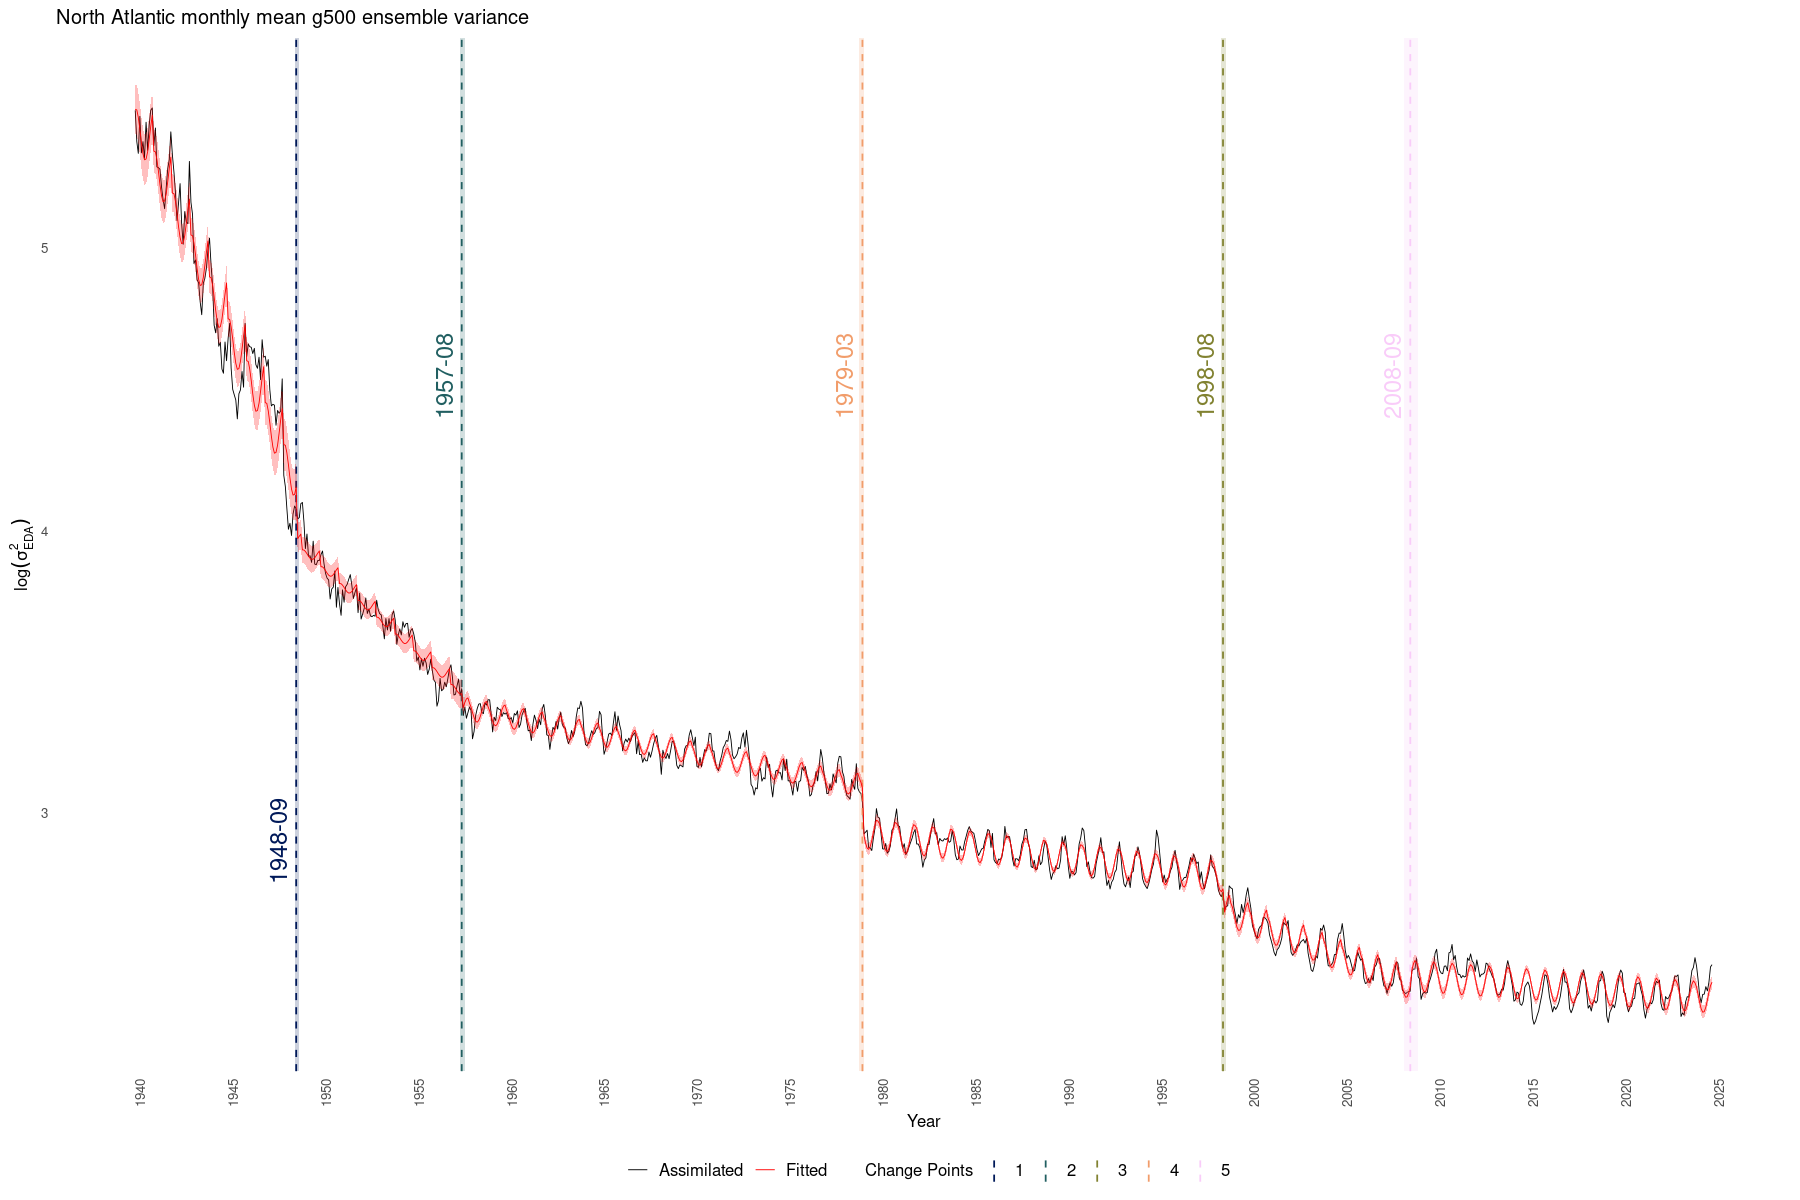

pdf 
  2

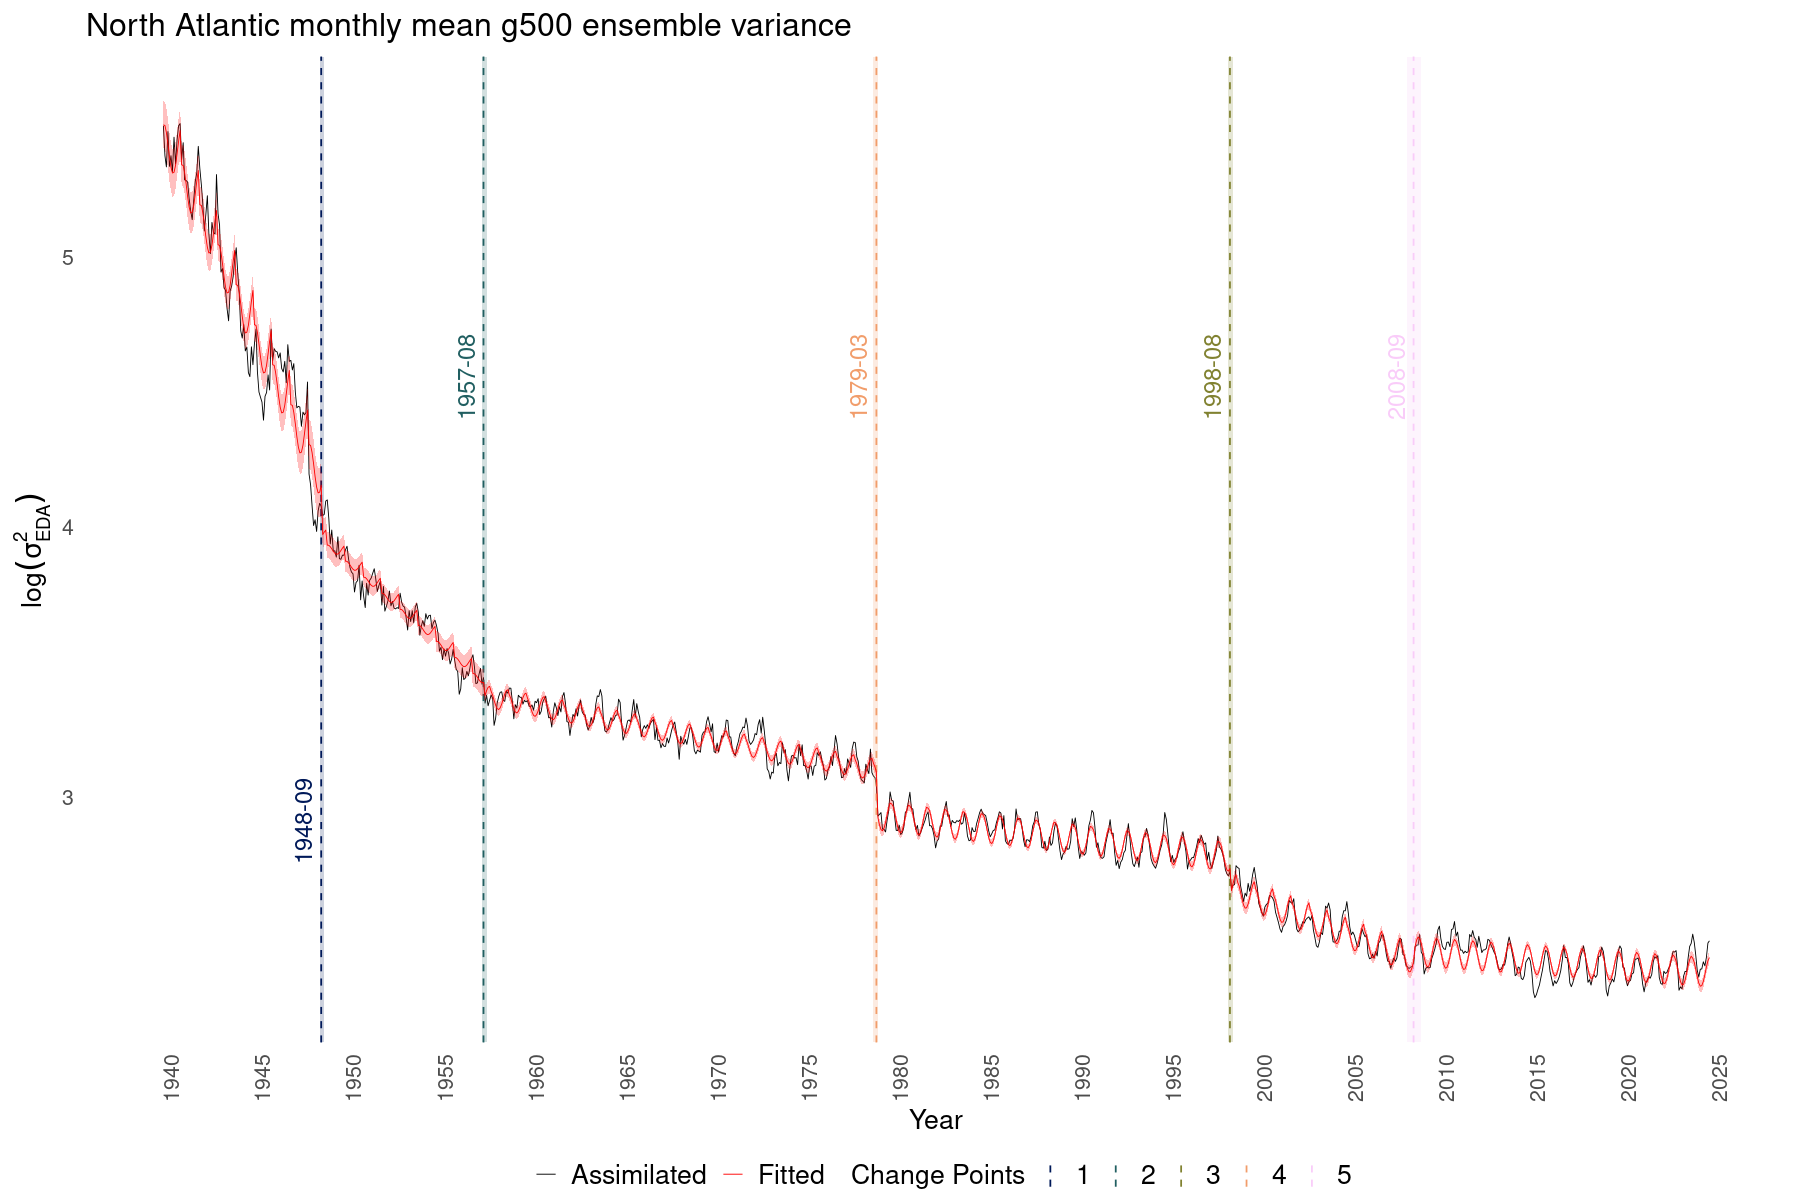

In [41]:
p <- plot_change_points(
    data = df,
    cp_df = cp_df,
    theme_pub = NULL,
    show_ci = TRUE
)
p

fitted_layers <- add_fitted_line_ci(lmod_seas_monthly, df)
for (layer in fitted_layers) {
    p <- p + layer
}

# Optional: Combine the legends for size and linetype into one "Data" legend
p <- p + guides(
    size = guide_legend(order = 1),
    linetype = guide_legend(order = 2),
    color = guide_legend(order = 3)
)

p

save_plot(p, "ChangePoints.pdf")

p <- p + THEME_PUB_LARGE
p
save_plot(p, "ChangePointsLarge.pdf", width = 9.5, height = 4.25)


### Have a look at the seasonal cycles for each segment and for the whole period
- We want uncertainties for amplitude and phase. 
- We want to use a parametric bootstrap for this (draw parameters from the betas according to their mean and covariance estimates)
- This is only ok if the residuals are approximately normally distributed, do we need to check

Shapiro-Wilk‐Test (standardisierte Residuen): Gut, wenn p>0.05 

	Shapiro-Wilk normality test

data:  std_resid
W = 0.99886, p-value = 0.7824



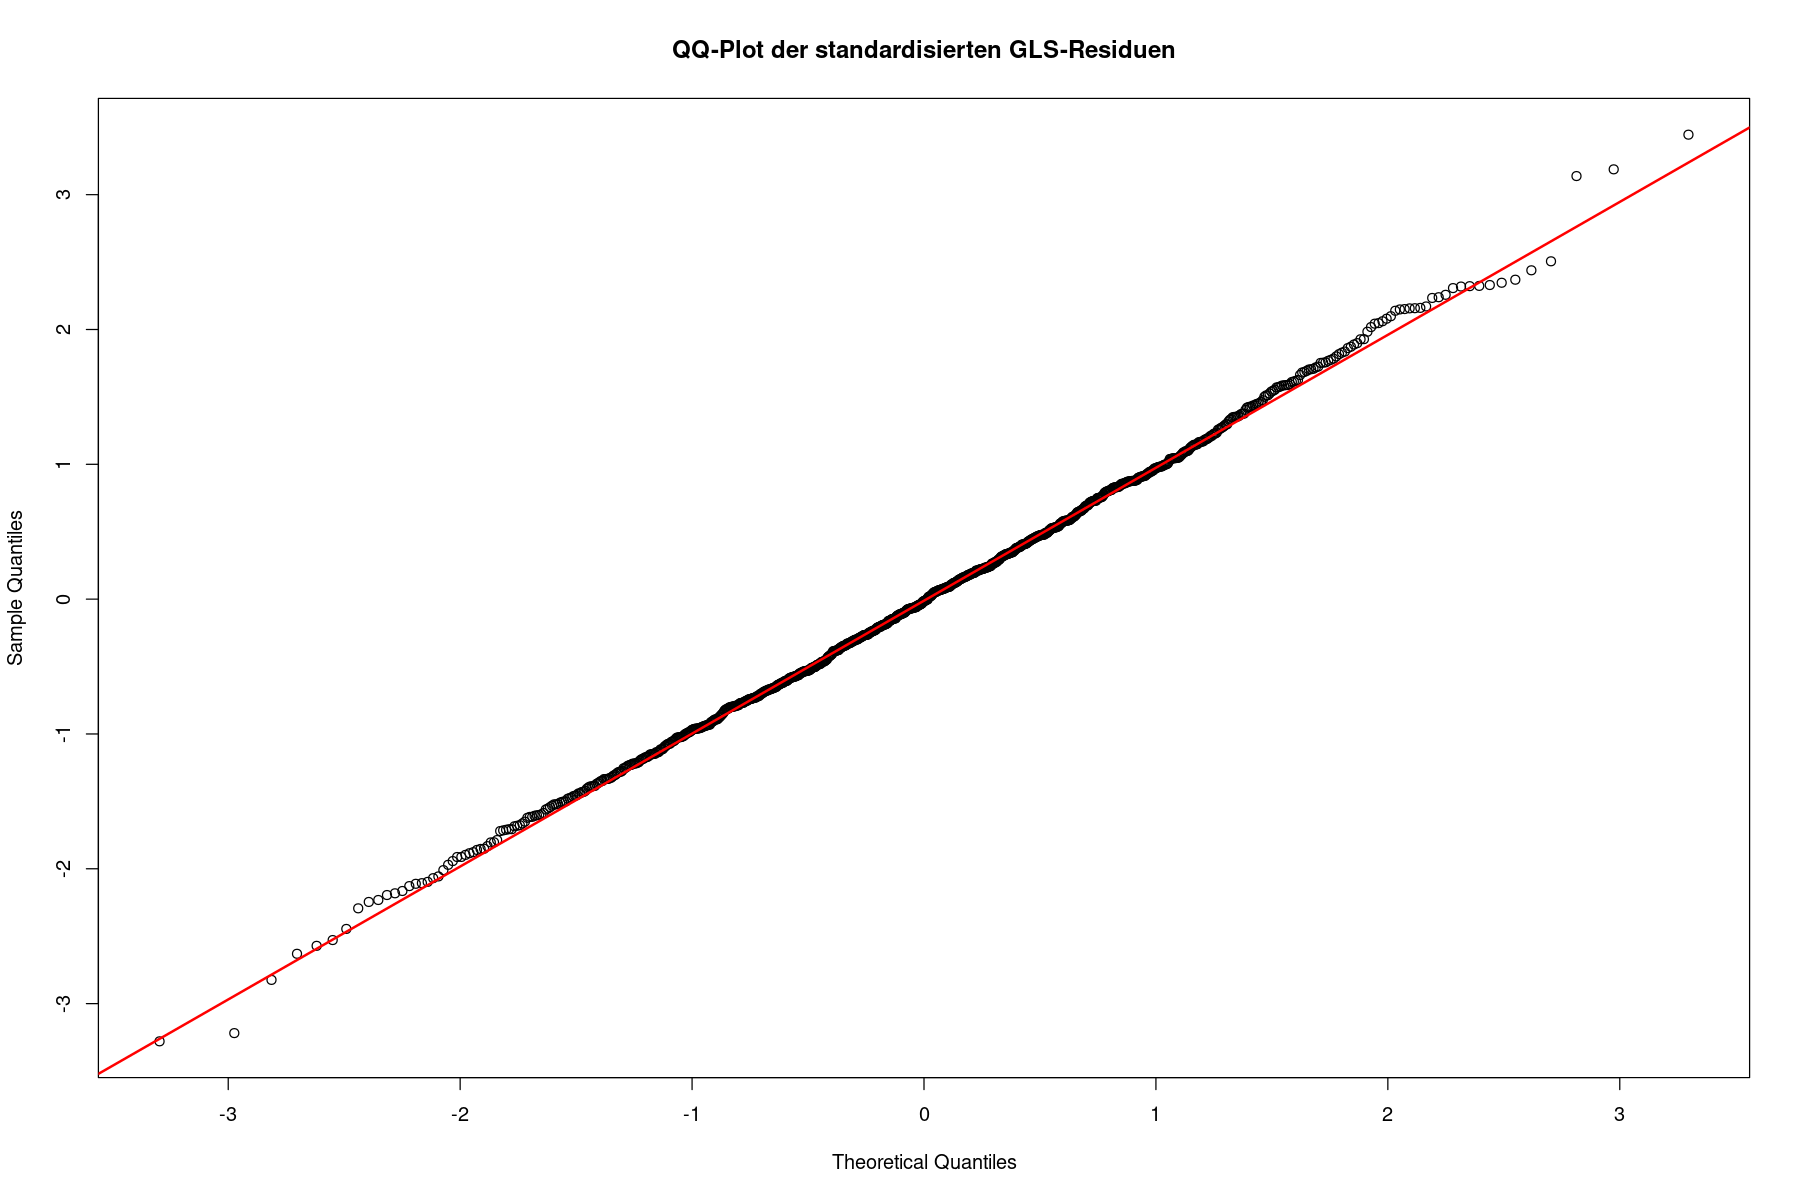

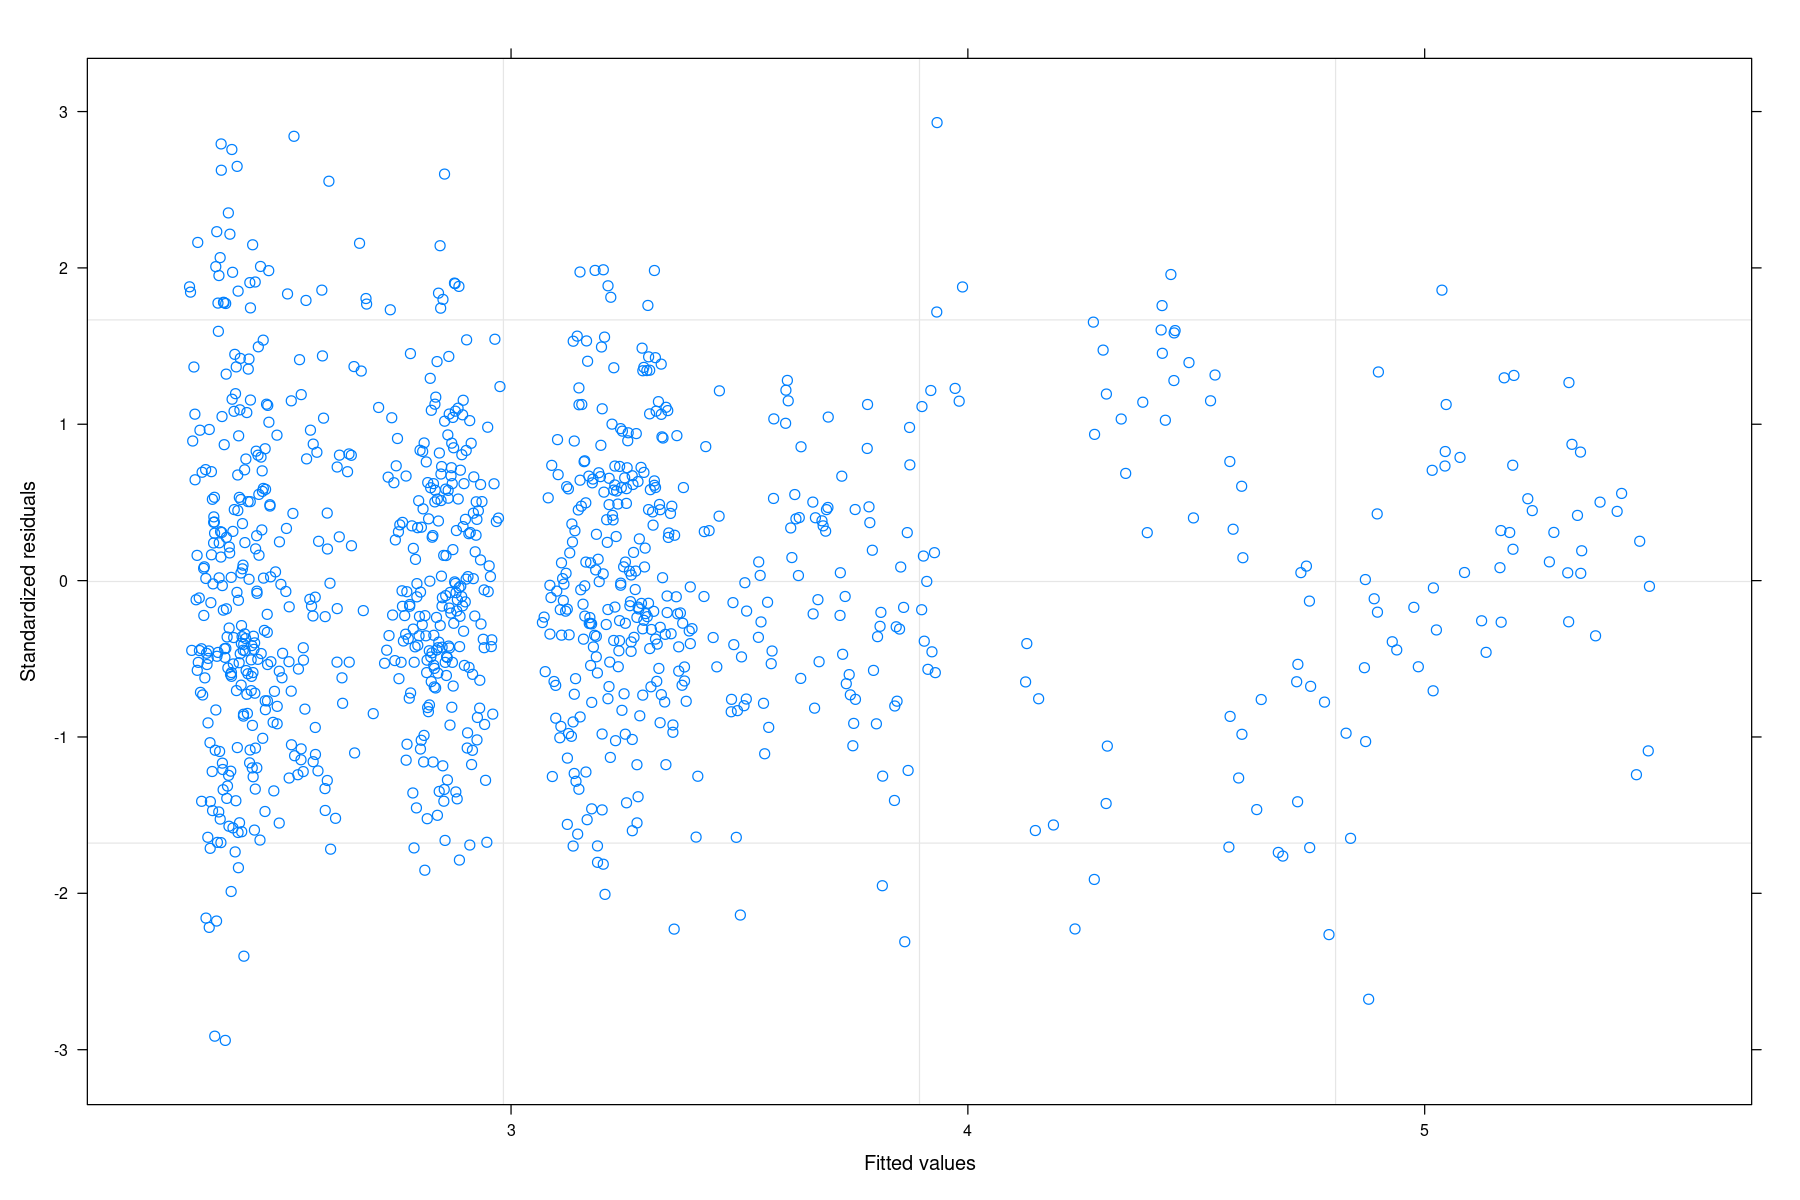

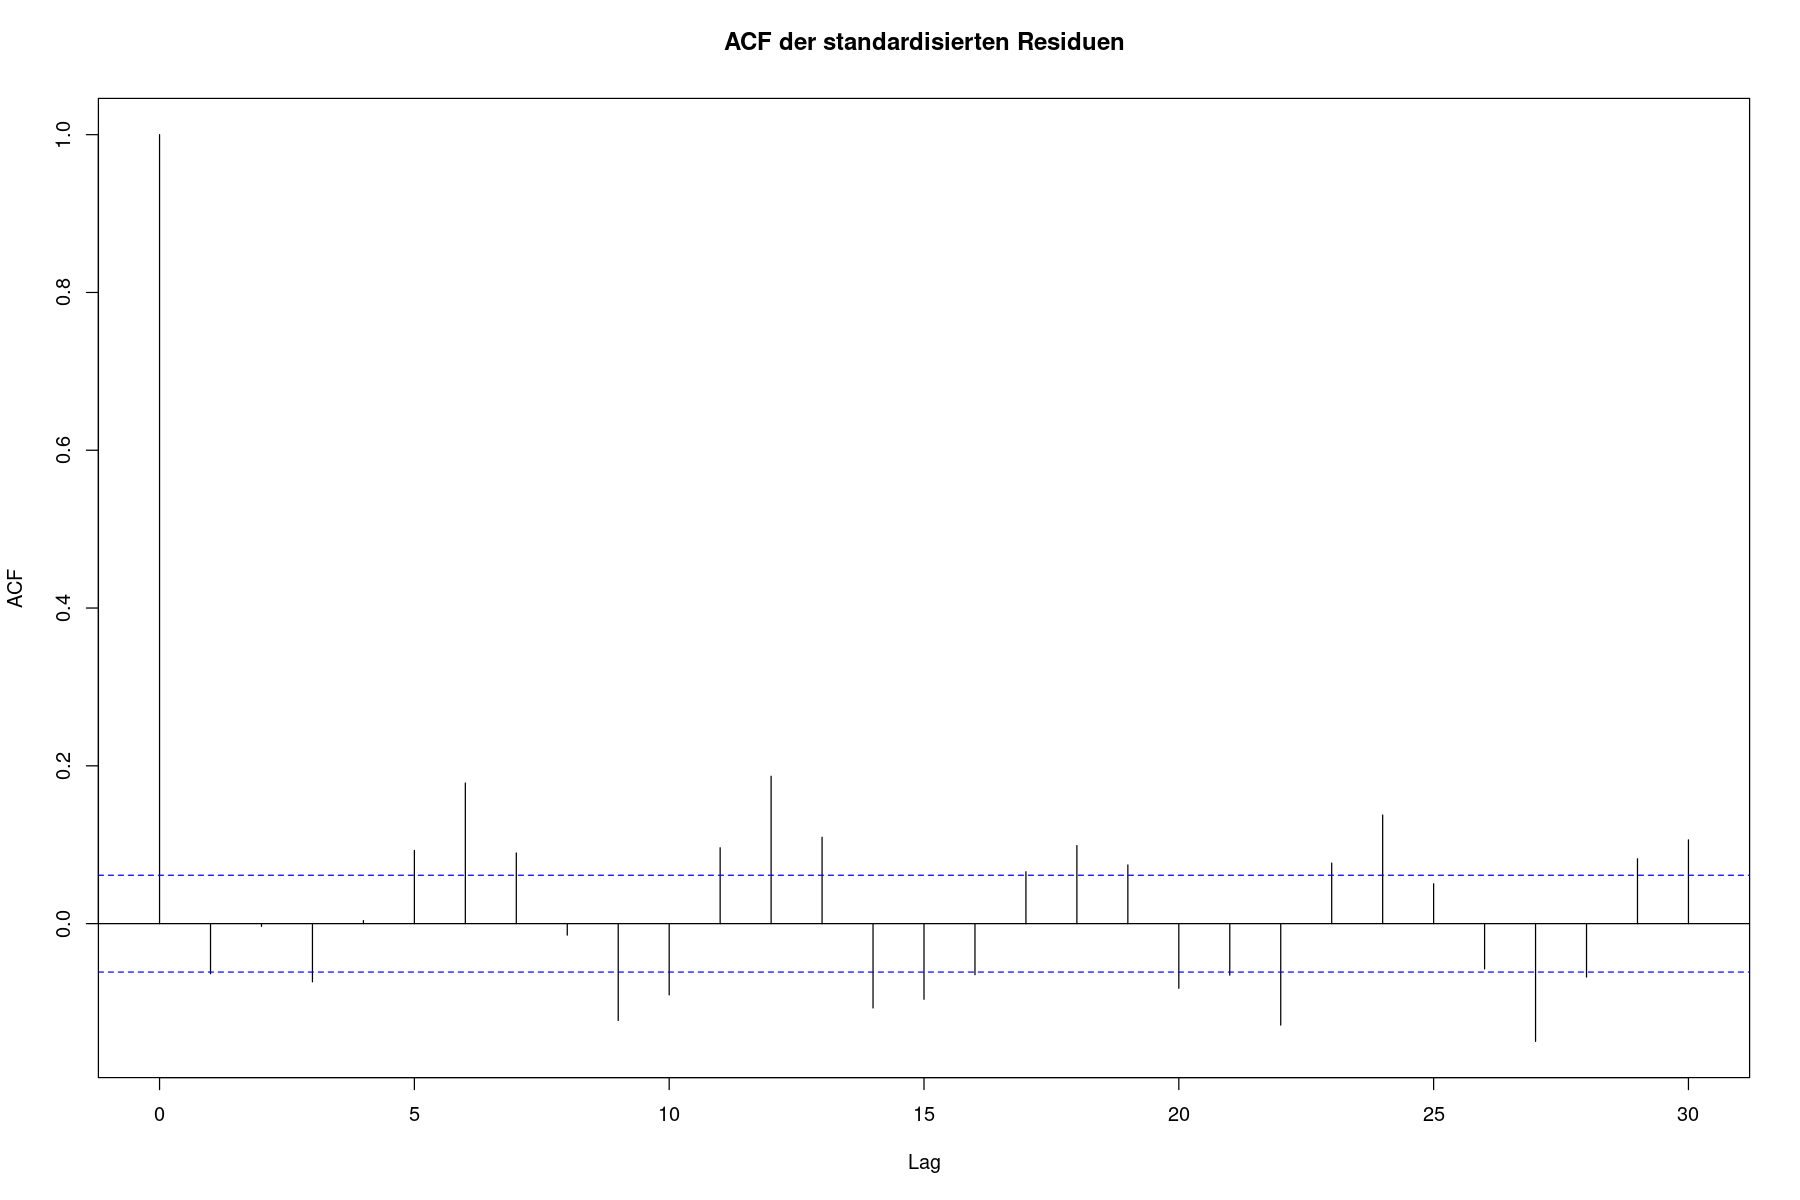

In [20]:
std_resid <- resid(lmod_seas_monthly, type = "normalized")
# “normalized” residuum sind so skaliert, dass sie etwa std-norm verteilt sein sollten.

# 2a) Shapiro-Wilk-Test auf Normalität der standardisierten Residuen
shapiro_std <- shapiro.test(std_resid)
cat("Shapiro-Wilk‐Test (standardisierte Residuen): Gut, wenn p>0.05 \n")
print(shapiro_std)
par(bg = "white")
qqnorm(std_resid, main = "QQ-Plot der standardisierten GLS-Residuen")
qqline(std_resid, col = "red", lwd = 2)
plot(lmod_seas_monthly)
acf(std_resid, main = "ACF der standardisierten Residuen")


pdf 
  2

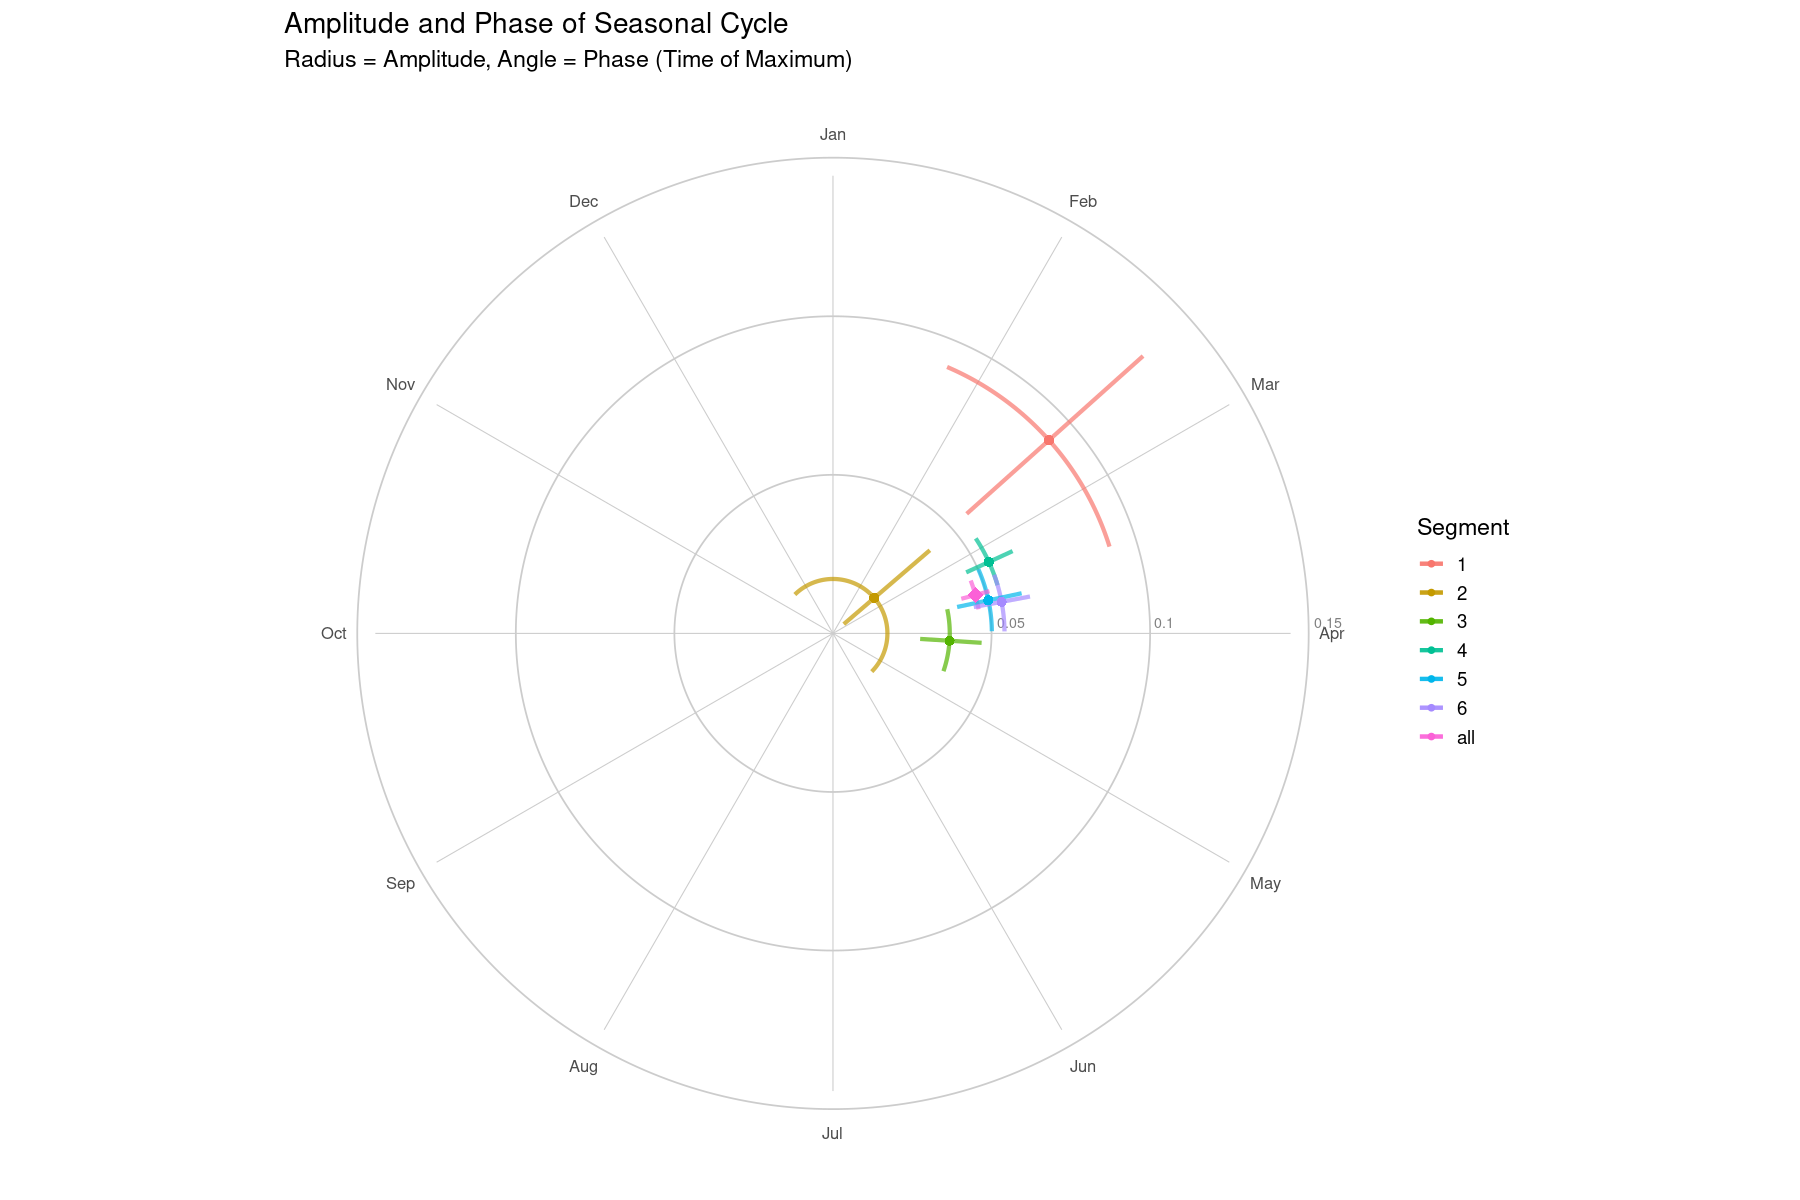

In [21]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Helper: Normiere Winkel auf [0, 2π)
# ─────────────────────────────────────────────────────────────────────────────
to_positive <- function(angle) {
    a <- angle %% (2 * pi)
    ifelse(a < 0, a + 2 * pi, a)
}

# ─────────────────────────────────────────────────────────────────────────────
# 2. Ermittle kleinstes 95%-Intervall auf dem Kreis (kürzeste Bogensegment)
# ─────────────────────────────────────────────────────────────────────────────
circular_CI <- function(angles, alpha = 0.05) {
    # Normiere auf [0, 2π)
    ang <- to_positive(angles)
    n <- length(ang)
    m <- floor((1 - alpha) * n)
    # Sortiere
    ang_sorted <- sort(ang)
    # Erweitere zweifach um 2π für Wrap-Around-Suche
    ang_ext <- c(ang_sorted, ang_sorted + 2 * pi)
    # Finde Fenster der Größe m mit minimalem Bogen
    ends <- ang_ext[(m + 1):(length(ang_ext))]
    starts <- ang_ext[1:(length(ang_ext) - m)]
    widths <- ends - starts
    idx_min <- which.min(widths)
    lower <- starts[idx_min] %% (2 * pi)
    upper <- ends[idx_min] %% (2 * pi)
    list(lower = lower, upper = upper)
}

# ─────────────────────────────────────────────────────────────────────────────
# 3. Bootstrap‐CI‐Berechnung für Amplitude & Phase
# ─────────────────────────────────────────────────────────────────────────────
get_seasonal_CI <- function(gls_model, B = 5000, alpha = 0.05) {
    beta_all <- coef(gls_model)
    varBeta <- gls_model$varBeta
    fe_names <- names(beta_all)

    # Look for sin/cos patterns - handle both segment-specific and global
    idx_sin <- grep("sin_mon", fe_names)
    idx_cos <- grep("cos_mon", fe_names)

    if (length(idx_sin) == 0 || length(idx_cos) == 0) {
        return(tibble())
    }

    # Extract segment names or use "seasonal_model" for global
    seg_sin <- ifelse(grepl(":", fe_names[idx_sin]),
        sub(":sin_mon$", "", fe_names[idx_sin]),
        "seasonal_model"
    )
    seg_cos <- ifelse(grepl(":", fe_names[idx_cos]),
        sub(":cos_mon$", "", fe_names[idx_cos]),
        "seasonal_model"
    )

    segments <- intersect(seg_sin, seg_cos)
    if (length(segments) == 0) {
        return(tibble())
    }

    idx_sin_matched <- idx_sin[match(segments, seg_sin)]
    idx_cos_matched <- idx_cos[match(segments, seg_cos)]

    beta_sin_hat <- beta_all[idx_sin_matched]
    beta_cos_hat <- beta_all[idx_cos_matched]
    R_hat <- sqrt(beta_sin_hat^2 + beta_cos_hat^2)
    phi_hat <- atan2(beta_sin_hat, beta_cos_hat)
    phi_hat_pos <- to_positive(phi_hat)

    Sigma_sc <- varBeta[c(idx_sin_matched, idx_cos_matched), c(idx_sin_matched, idx_cos_matched)]
    mu_sc <- beta_all[c(idx_sin_matched, idx_cos_matched)]

    if (nrow(Sigma_sc) == 0) {
        return(tibble())
    }

    BSim <- MASS::mvrnorm(n = B, mu = mu_sc, Sigma = Sigma_sc)
    S <- length(segments)

    A_boot <- sqrt(BSim[, 1:S, drop = FALSE]^2 + BSim[, (S + 1):(2 * S), drop = FALSE]^2)
    phi_boot_raw <- atan2(BSim[, 1:S, drop = FALSE], BSim[, (S + 1):(2 * S), drop = FALSE])

    CI_R <- apply(A_boot, 2, function(x) quantile(x, probs = c(alpha / 2, 1 - alpha / 2)))
    CI_phi <- map_dfr(seq_len(S), function(j) {
        cci <- circular_CI(phi_boot_raw[, j], alpha = alpha)
        tibble(phi_lwr = cci$lower, phi_upr = cci$upper)
    })

    tibble(
        segment = segments,
        R = R_hat, phi = phi_hat_pos,
        R_lwr = CI_R[1, ], R_upr = CI_R[2, ]
    ) %>%
        bind_cols(CI_phi) %>%
        mutate(
            x = R * cos(phi), y = R * sin(phi),
            x_lwr = R_lwr * cos(phi), y_lwr = R_lwr * sin(phi),
            x_upr = R_upr * cos(phi), y_upr = R_upr * sin(phi),
            segment_clean = case_when(
                segment == "seasonal_model" ~ "all",
                grepl("^segment", segment) ~ gsub("segment", "", segment),
                TRUE ~ segment
            )
        )
}

# ─────────────────────────────────────────────────────────────────────────────
# 4. Hilfsfunktionen für den Polar‐Plot
# ─────────────────────────────────────────────────────────────────────────────
make_circle <- function(r, n = 360) {
    tibble(
        theta = seq(0, 2 * pi, length.out = n),
        x = r * cos(theta),
        y = r * sin(theta),
        radius = r # Add radius identifier for grouping
    )
}

make_arc_segments <- function(df_ci, n_points = 100) {
    map_df(seq_len(nrow(df_ci)), function(i) {
        R_seg <- df_ci$R[i]
        angle_lo <- df_ci$phi_lwr[i]
        angle_hi <- df_ci$phi_upr[i]
        # Handle wrap-around
        if (angle_hi < angle_lo) angle_hi <- angle_hi + 2 * pi
        angles <- seq(angle_lo, angle_hi, length.out = n_points)
        tibble(
            segment_clean = df_ci$segment_clean[i], # Use cleaned segment names
            x_arc = R_seg * cos(angles),
            y_arc = R_seg * sin(angles),
            id = i
        )
    })
}

# Fixed grid function - creates concentric circles
make_grid <- function(R_max, n_levels = 4) {
    levels <- pretty(c(0, R_max), n = n_levels)
    levels <- levels[levels > 0] # Remove zero level
    map_df(levels, make_circle)
}

# Simplified month lines - one line per month
make_month_lines <- function(R_max) {
    # Start from January at top (π/2) and go clockwise
    month_angles <- seq(pi / 2, pi / 2 - 2 * pi, length.out = 13)[1:12]
    month_labels <- c(
        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
    )
    tibble(
        angle   = month_angles,
        x       = 0,
        y       = 0,
        xend    = R_max * 1.1 * cos(angle), # Extend slightly beyond max radius
        yend    = R_max * 1.1 * sin(angle),
        label_x = R_max * 1.2 * cos(angle), # Place labels further out
        label_y = R_max * 1.2 * sin(angle),
        label   = month_labels
    )
}

# Add function to create radius labels
make_radius_labels <- function(R_max, n_levels = 4) {
    levels <- pretty(c(0, R_max), n = n_levels)
    levels <- levels[levels > 0] # Remove zero level
    tibble(
        x = levels,
        y = 0,
        label = as.character(round(levels, 2))
    )
}

# ─────────────────────────────────────────────────────────────────────────────
# 5. Plot‐Funktion
# ─────────────────────────────────────────────────────────────────────────────
plot_seasonal_polar <- function(df_ci) {
    R_max <- max(df_ci$R_upr)
    grid_circles <- make_grid(R_max)
    month_lines <- make_month_lines(R_max)
    radius_labels <- make_radius_labels(R_max)
    arc_segments <- make_arc_segments(df_ci)

    ggplot() +
        # Concentric circles for radius grid
        geom_path(
            data = grid_circles, aes(x = x, y = y, group = radius),
            color = "grey80", linewidth = 0.5
        ) +
        # Month lines (radial lines)
        geom_segment(
            data = month_lines, aes(x = x, y = y, xend = xend, yend = yend),
            color = "grey80", linewidth = 0.3
        ) +
        # Month labels
        geom_text(
            data = month_lines, aes(x = label_x, y = label_y, label = label),
            size = 3.5, color = "grey30"
        ) +
        # Radius labels
        geom_text(
            data = radius_labels, aes(x = x, y = y, label = label),
            size = 3, color = "grey50", hjust = -0.2, vjust = -0.5
        ) +
        # Confidence intervals as arcs
        geom_path(
            data = arc_segments, aes(x = x_arc, y = y_arc, group = id, color = segment_clean),
            linewidth = 1.2, alpha = 0.7
        ) +
        # Radial confidence intervals
        geom_segment(
            data = df_ci, aes(x = x_lwr, y = y_lwr, xend = x_upr, yend = y_upr, color = segment_clean),
            linewidth = 1.2, alpha = 0.7
        ) +
        # Point estimates with different shapes/sizes for "all" vs individual segments
        geom_point(data = df_ci, aes(
            x = x, y = y, color = segment_clean,
            shape = segment_clean == "all",
            size = segment_clean == "all"
        )) +
        scale_size_manual(values = c("TRUE" = 4, "FALSE" = 2.5), guide = "none") +
        scale_shape_manual(values = c("TRUE" = 18, "FALSE" = 16), guide = "none") + # Diamond for "all", circle for segments
        coord_equal() +
        theme_minimal(base_size = 14) +
        theme(
            axis.title = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            panel.grid = element_blank(),
            panel.background = element_blank(),
            plot.background = element_blank(),
            legend.position = "right"
        ) +
        labs(
            title = "Amplitude and Phase of Seasonal Cycle",
            subtitle = "Radius = Amplitude, Angle = Phase (Time of Maximum)",
            color = "Segment"
        )
}

# ─────────────────────────────────────────────────────────────────────────────
# 6. Beispielaufruf - combine both models
# ─────────────────────────────────────────────────────────────────────────────
# Get CIs from both models and combine them
df_ci_segments <- get_seasonal_CI(lmod_seas_monthly, B = N_PERM)
df_ci_seasonal <- get_seasonal_CI(seasonal_model, B = N_PERM)

# Only combine if both have results
df_ci_combined <- bind_rows(
    df_ci_segments,
    df_ci_seasonal
) %>%
    filter(nrow(.) > 0) # Remove empty results

if (nrow(df_ci_combined) > 0) {
    p <- plot_seasonal_polar(df_ci_combined)
} else {
    cat("No seasonal parameters found in the models. Please check parameter names.\n")
    cat("Expected parameter names containing 'sin_mon' and 'cos_mon'.\n")
    cat("Segmented model parameters:", paste(names(coef(lmod_seas_monthly)), collapse = ", "), "\n")
    cat("Seasonal model parameters:", paste(names(coef(seasonal_model)), collapse = ", "), "\n")
}

p
save_plot(p, "SeasonalCyclePolarLarge.pdf", width = 6, height = 5)


# Watch our for Autocorrelation!
**All models fitted exhibit autocorrelation to a significant degree. This comes as no surprise, but demands choosing ARIMA over ordinary least squares**

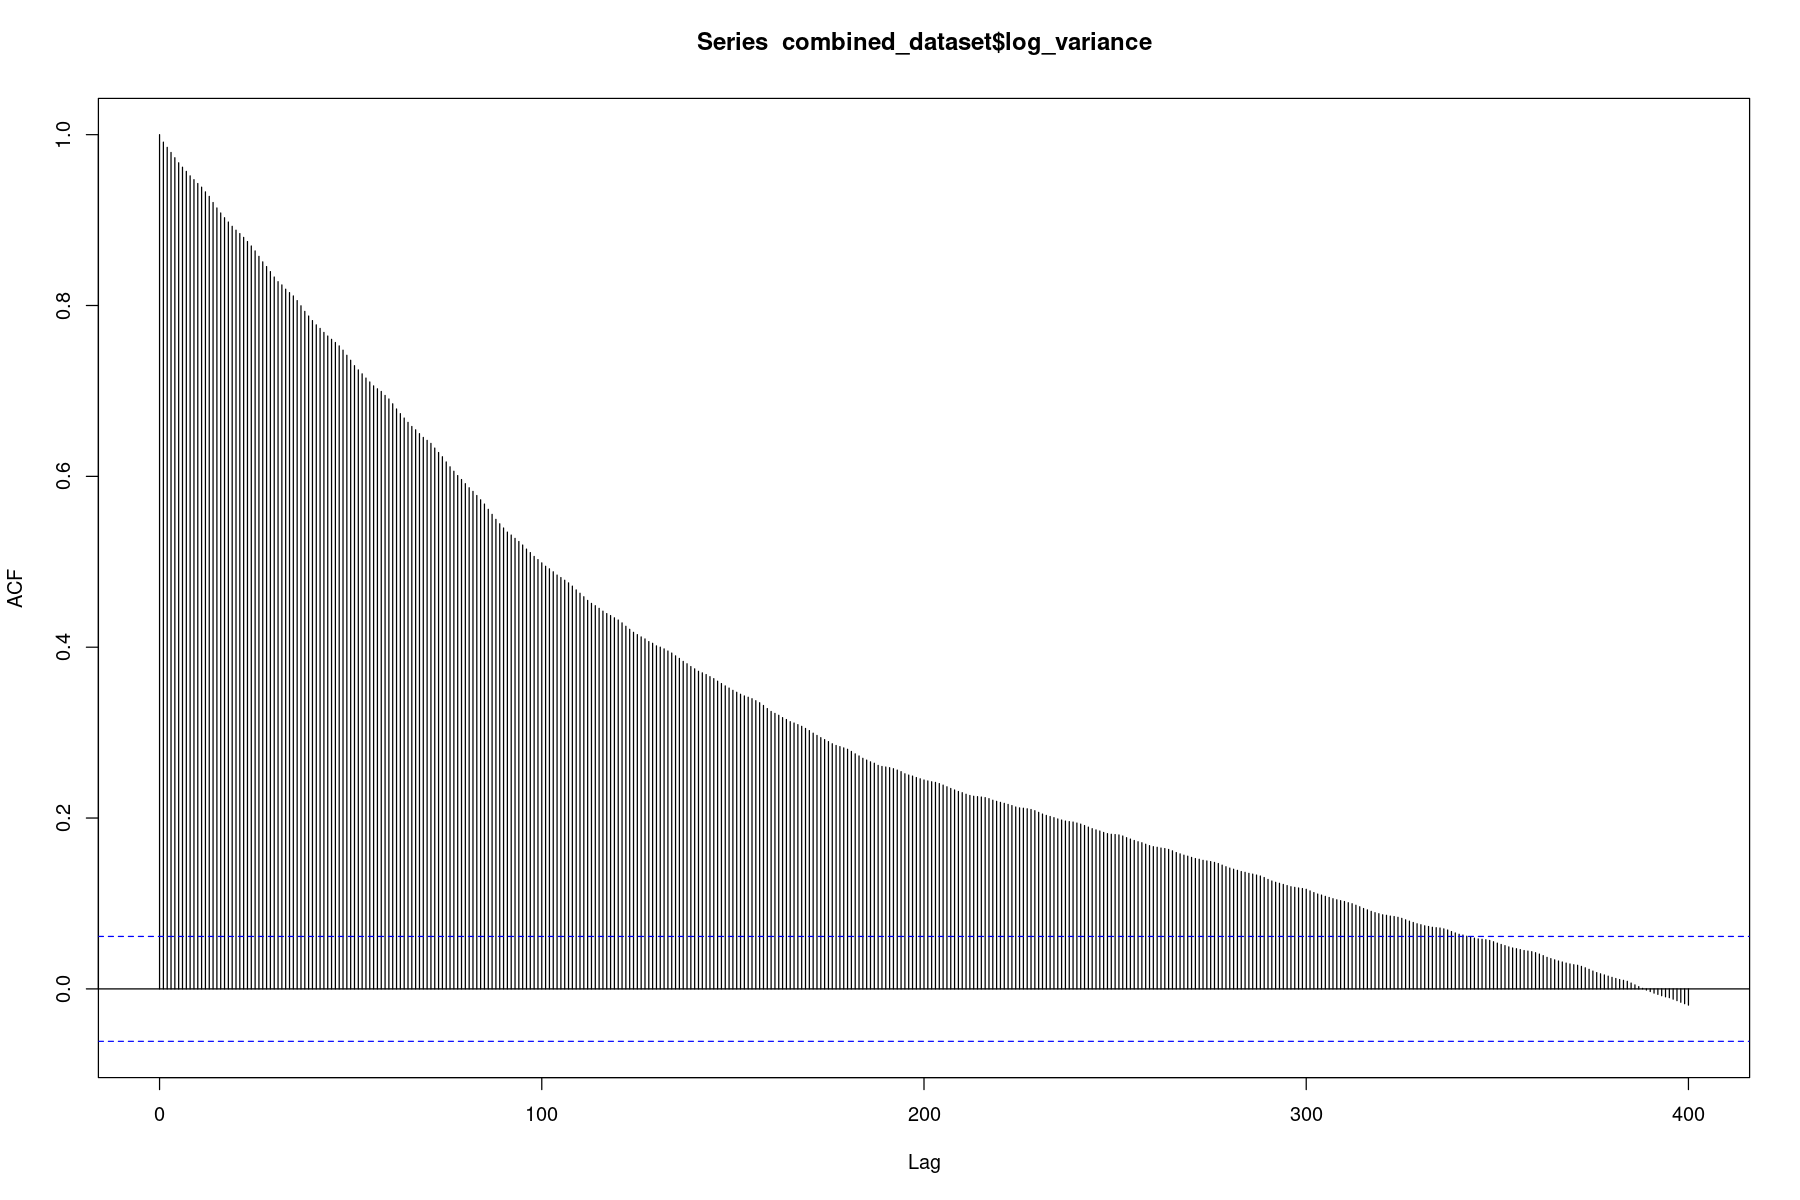

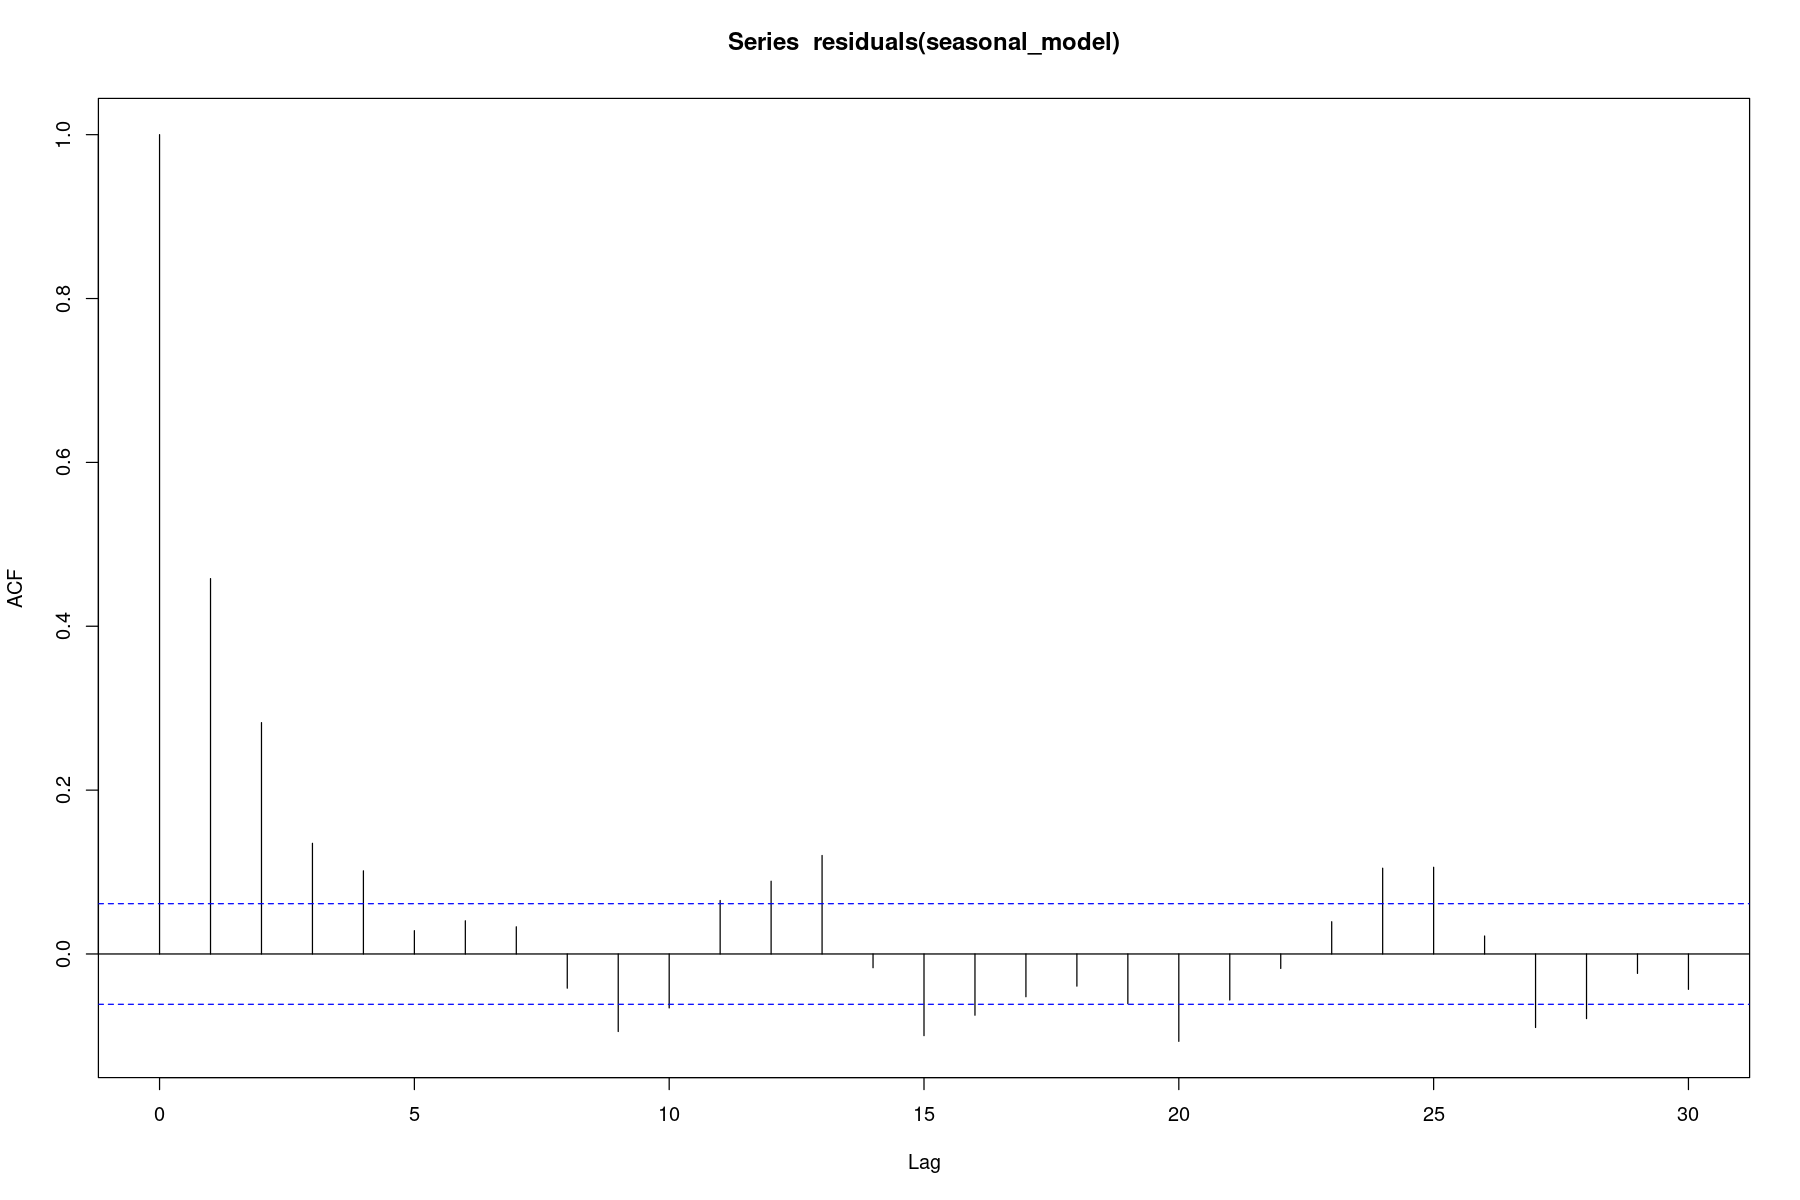

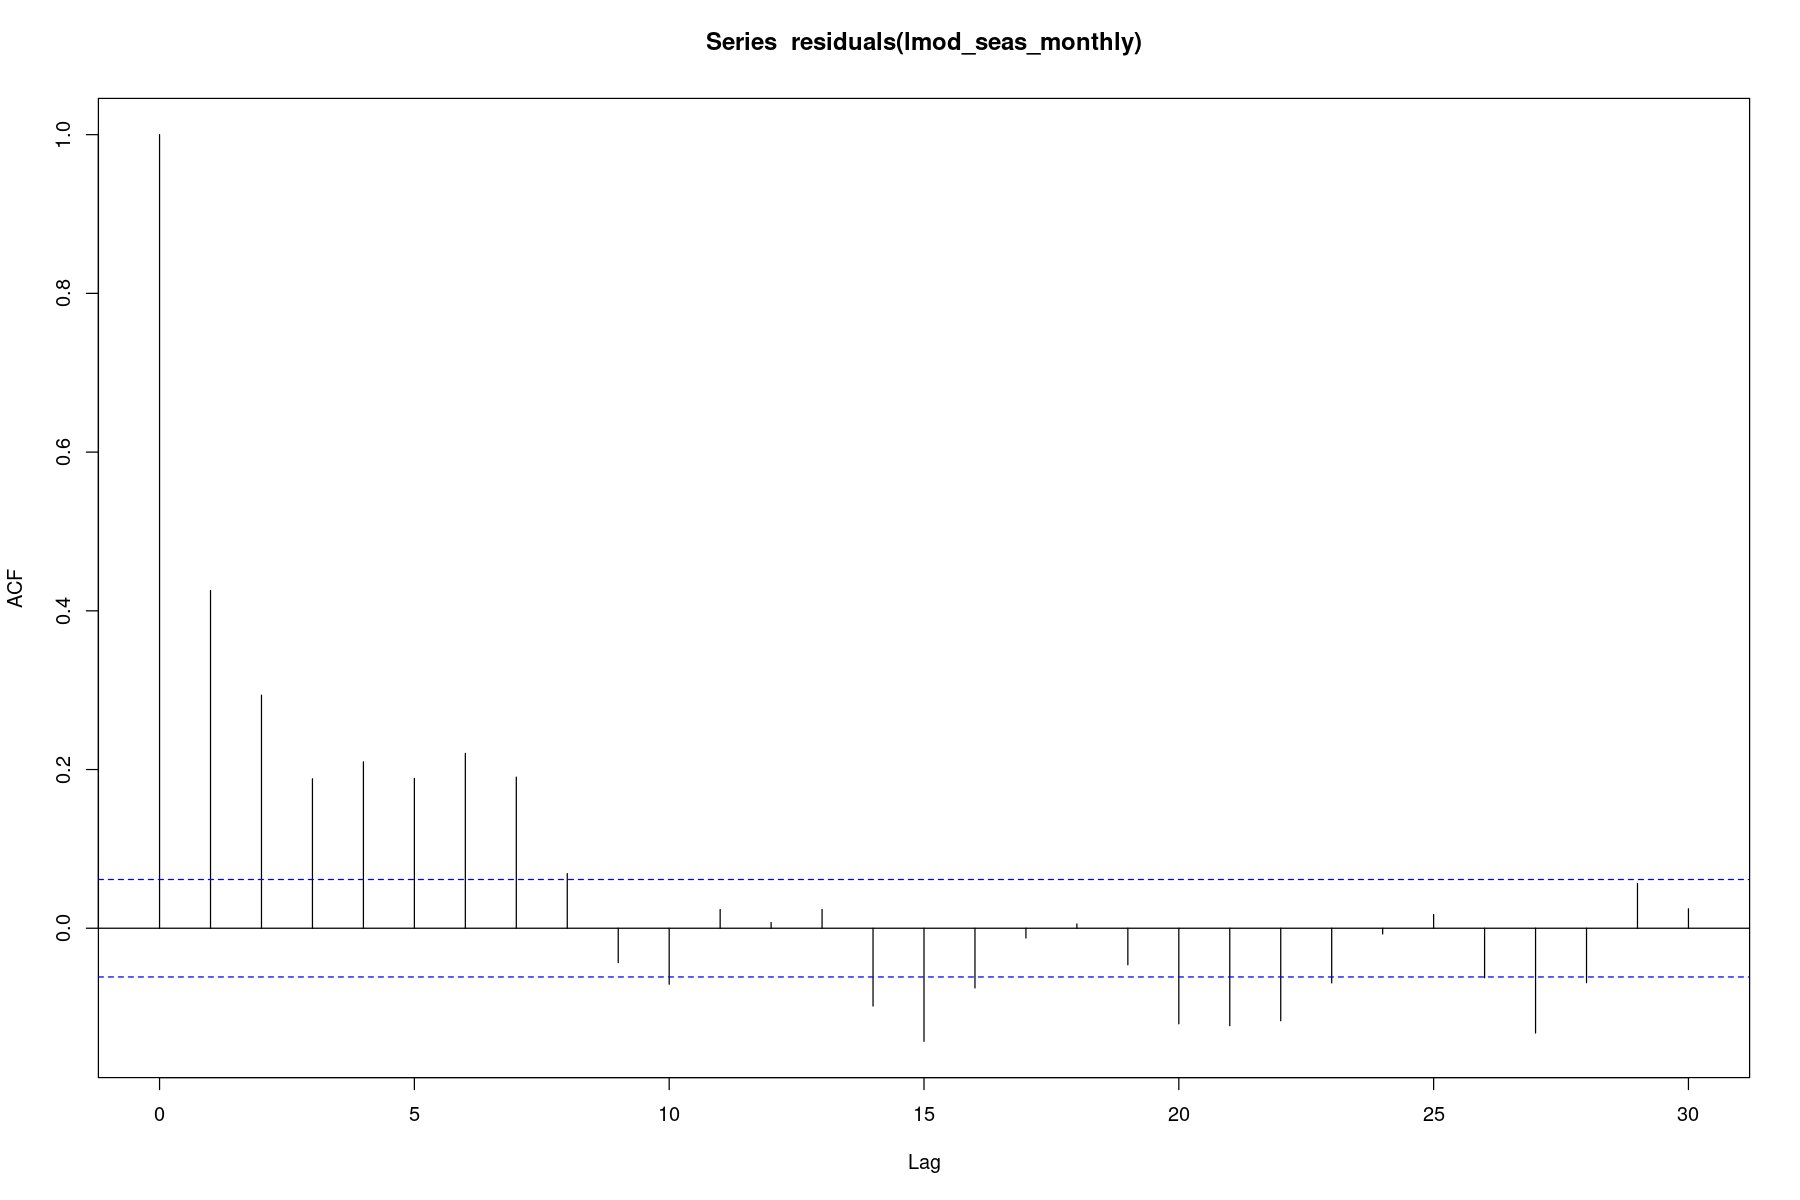

In [ ]:
par(bg = "white")
plot(acf(combined_dataset$log_variance, lag.max = 400))
plot(acf(residuals(seasonal_model), lag.max = 30))
plot(acf(residuals(lmod_seas_monthly), lag.max = 30))


## Binary Segmentation
- legacy code because breakpoints in regressions is more suitable

In [ ]:
flattened_data <- combined_dataset$avg_z
log_data <- log(flattened_data)

#---------------- Change Point Detection and Plotting ------------------------
max_cp_vec <- 1:4

# Prepare an empty data frame to accumulate change point info:
# cp_index: index in the time series
# cp_date: the corresponding date
# max_cp: the hierarchical level (i.e. the iteration when first found)
cp_df <- data.frame(
    cp_index = integer(),
    cp_date = as.Date(character()),
    max_cp = integer(),
    stringsAsFactors = FALSE
)

# Loop over each max_cp value and detect change points hierarchically.
for (i in seq_along(max_cp_vec)) {
    max_cp <- max_cp_vec[i]
    cpt_obj <- cpt.mean(log_data,
        method = "BinSeg", Q = max_cp,
        class = TRUE
    )
    # cpts() returns the indices of the change points (including the final index)
    cps <- cpts(cpt_obj)
    cps <- cps[cps < length(flattened_data)]

    # Save only newly found change points
    new_cps <- cps[!cps %in% cp_df$cp_index]

    if (length(new_cps) > 0) {
        for (cp in new_cps) {
            cp_df <- rbind(
                cp_df,
                data.frame(
                    cp_index = cp,
                    cp_date = combined_dataset$date[cp],
                    max_cp = max_cp,
                    stringsAsFactors = FALSE
                )
            )
        }
        cat(
            "Max change points:", max_cp,
            "-> New cp detected at indices:", paste(new_cps, collapse = ", "),
            "which correspond to dates:",
            paste(as.character(combined_dataset$date[new_cps]),
                collapse = ", "
            ), "\n"
        )
    } else {
        cat(
            "Max change points:", max_cp,
            "-> No new change points detected.\n"
        )
    }
}

#--- Build the base plot using actual date values on the x-axis ---------------
p <- ggplot(data = combined_dataset, aes(x = date, y = avg_z)) +
    geom_line() +
    scale_y_log10() +
    labs(
        x = "Time", y = "Log(Var)",
        title = "Original Data with Detected Change Points",
        color = "Hierarchy"
    ) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    THEME_PUB +
    scale_x_date(date_breaks = "5 year", date_labels = "%Y") +
    scale_color_scico_d(palette = "batlow") # discrete colour scale

#--- Add vertical lines and annotations for change points --------------------
if (nrow(cp_df) > 0) {
    y_pos <- max(combined_dataset$avg_z, na.rm = TRUE) * .7
    p <- p +
        geom_vline(
            data = cp_df, aes(
                xintercept = cp_date,
                color = factor(max_cp)
            ),
            linetype = "dashed", linewidth = 1
        ) +
        geom_text(
            data = cp_df, aes(
                x = cp_date, y = y_pos,
                label = format(cp_date, "%Y-%m"),
                color = factor(max_cp)
            ),
            angle = 90, vjust = -0.5, hjust = 0, size = 5, show.legend = FALSE
        ) +
        guides(color = guide_legend(
            override.aes = list(
                shape = NA,
                linetype = "dashed"
            )
        )) +
        theme(
            legend.title = element_text(size = 18),
            legend.text = element_text(size = 18),
            legend.key.size = unit(2, "lines")
        )
}

#--- Display the plot ---------------------------------------------------------
print(p)

#--- Print out the exact time values (and indices) identified ----------------
if (nrow(cp_df) > 0) {
    cat("Detected change points:\n")
    print(cp_df)
} else {
    cat("No change points detected in the final run.\n")
}


In [ ]:
max_cp_vec <- 1:4

# Detect change points
cp_df <- detect_change_points(
    log_data,
    combined_dataset$date,
    max_cp_vec
)

# Create the plot (THEME_PUB can be passed if defined)
p <- plot_change_points(combined_dataset, cp_df, theme_pub = THEME_PUB)

# Display the plot
print(p)

# Print the detected change points
if (nrow(cp_df) > 0) {
    cat("Detected change points:\n")
    print(cp_df)
} else {
    cat("No change points detected in the final run.\n")
}
